In [1]:
#All libraries import here
import torch
import torch.nn as nn
import torch.optim as optim
import requests
import json
import pandas as pd
import datetime as dt
import time
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import ray
from ray import tune
import seaborn as sns
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial
import matplotlib.dates as mdates

# Modelling for daily dataset using 8 features with lstm layer

## 1. Data preprocessing

Data has been loaded first with daily data points, with a copy of the daily data points, we calculate 7 extra features from the original dataset and normalise them.

In [2]:
df = pd.read_csv('BTCUSDT_daily.csv')
df.head(14)

,Date,Open,High,Low,Close,Volume
0,2018-01-01 11:00:00,13715.65,13818.55,12750.00,13380.00,8609.915844
1,2018-01-02 11:00:00,13382.16,15473.49,12890.02,14675.11,20078.092111
2,2018-01-03 11:00:00,14690.00,15307.56,14150.00,14919.51,15905.667639
3,2018-01-04 11:00:00,14919.51,15280.00,13918.04,15059.54,21329.649574
4,2018-01-05 11:00:00,15059.56,17176.24,14600.00,16960.39,23251.491125
5,2018-01-06 11:00:00,16960.39,17143.13,16011.21,17069.79,18571.457508
6,2018-01-07 11:00:00,17069.79,17099.96,15610.00,16150.03,12493.125558
7,2018-01-08 11:00:00,16218.85,16322.30,12812.00,14902.54,26600.609912
8,2018-01-09 11:00:00,14902.54,15500.00,14011.05,14400.00,14315.004253
9,2018-01-10 11:00:00,14401.00,14955.66,13131.31,14907.09,17411.001655



In our pipeline we applied **min–max normalisation** separately to each feature column so that all values fall within the `[0, 1]` interval. For each raw value \(x\) in a column, we compute:


x_norm = (x - x_min) / (x_max - x_min)

where `x_min` and `x_max` are that column’s global minimum and maximum. This ensures the smallest observed value becomes 0 and the largest becomes 1, with all other points mapped linearly in between. However, when a feature contains extreme outliers—e.g. one day’s trading volume spikes to 750 000 while typical days are around 40,000—then most values collapse near the lower end of [0, 1]:

(40000 - 0) / (750000 - 0) = 0.053

Conversely, if values cluster near the maximum, normalised results will crowd near 1. Therefore, min–max scaling can yield very small (close to 0) or very large (close to 1) normalised numbers whenever the raw data span a wide or skewed range.


In [5]:
# Make a copy of the DataFrame to avoid SettingWithCopyWarning
df_copy = df.copy()

# ---------- 1. Calculate Technical Indicators ----------

# Log Returns
df_copy['LogReturns'] = np.log(df_copy['Close'] / df_copy['Close'].shift(1))

# Parkinson Volatility
df_copy['Volatility'] = (np.log(df_copy['High']) - np.log(df_copy['Low'])) ** 2 / (4 * np.log(2))

# back 14-day SMA and EMA
df_copy['SMA_14'] = df_copy['Close'].rolling(window=14).mean()
# 14-day RSI
delta = df_copy['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df_copy['RSI_14'] = 100 - (100 / (1 + rs))

# OBV
obv = [0]
for i in range(1, len(df_copy)):
    if df_copy['Close'].iloc[i] > df_copy['Close'].iloc[i - 1]:
        obv.append(obv[-1] + df_copy['Volume'].iloc[i])
    elif df_copy['Close'].iloc[i] < df_copy['Close'].iloc[i - 1]:
        obv.append(obv[-1] - df_copy['Volume'].iloc[i])
    else:
        obv.append(obv[-1])
df_copy['OBV'] = obv

# ATR (14-day)
high_low = df_copy['High'] - df_copy['Low']
high_close = np.abs(df_copy['High'] - df_copy['Close'].shift(1))
low_close = np.abs(df_copy['Low'] - df_copy['Close'].shift(1))
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df_copy['ATR_14'] = tr.rolling(window=14).mean()

# Drop rows with NaNs from rolling windows
df_copy = df_copy.dropna()

# ---------- 2. Normalize All 8 Features ----------
features_to_scale = ['LogReturns', 'Volume', 'Volatility', 'SMA_14', 'RSI_14', 'OBV', 'ATR_14']
scaler = MinMaxScaler(feature_range=(0, 1))

for feature in features_to_scale:
    df_copy.loc[:, f'{feature}_Norm'] = scaler.fit_transform(df_copy[feature].values.reshape(-1, 1)).flatten()

# ---------- 3. Create Sequences Using the Normalised Features ----------
def create_multifeature_sequences(data, feature_columns, seq_length=3):
    # Pre-allocate arrays
    n_samples = len(data) - seq_length
    n_features = len(feature_columns)
    X = np.zeros((n_samples, seq_length, n_features), dtype=np.float32)
    y = np.zeros(n_samples, dtype=np.float32)
    
    for i in range(n_samples):
        # Build the sequence for each sample
        for j in range(seq_length):
            X[i, j, :] = data.iloc[i + j][feature_columns].values
        # Target is the next raw LogReturns value
        y[i] = data.iloc[i + seq_length]['LogReturns']
    
    return X, y

# Use all 8 normalized features
feature_columns = ['LogReturns_Norm', 'Volume_Norm', 'Volatility_Norm'
                   ,'SMA_14_Norm'
                   #, 'EMA_14_Norm'
                   , 'RSI_14_Norm'
                   , 'OBV_Norm'
                   , 'ATR_14_Norm'
                  ]
X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)


In [96]:
df_copy

,Date,Open,High,Low,Close,Volume,LogReturns,Volatility,SMA_14,RSI_14,OBV,ATR_14,LogReturns_Norm,Volume_Norm,Volatility_Norm,SMA_14_Norm,RSI_14_Norm,OBV_Norm,ATR_14_Norm
14,2018-01-15 11:00:00,13477.98,14249.99,13147.79,13539.93,14652.094705,0.004808,0.002337,14803.407857,50.775896,55856.767179,1860.680000,0.745042,0.017583,0.018501,0.113630,0.484936,0.475056,0.294187
15,2018-01-16 11:00:00,13500.00,13542.93,9035.00,10900.00,63401.169175,-0.216880,0.059089,14533.757143,33.799160,-7544.401996,1998.141429,0.419535,0.081777,0.468509,0.110938,0.305204,0.468014,0.316867
16,2018-01-17 11:00:00,10899.99,11680.99,9037.94,10988.79,72331.796646,0.008113,0.023735,14252.991429,32.903015,64787.394650,2104.247857,0.749895,0.093537,0.188175,0.108135,0.295717,0.476048,0.334373
17,2018-01-18 11:00:00,10972.59,11878.82,10435.33,10961.97,48464.434937,-0.002444,0.006054,13960.307857,32.000018,16322.959713,2110.071429,0.734394,0.062108,0.047973,0.105212,0.286157,0.470665,0.335334
18,2018-01-19 11:00:00,10960.00,11795.00,10360.00,11474.98,34129.375421,0.045737,0.006069,13568.492857,22.557335,50452.335134,2028.554286,0.805138,0.043231,0.048095,0.101300,0.186188,0.474456,0.321884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642,2025-03-27 11:00:00,86909.17,87756.39,85800.00,87232.01,17098.038970,0.003708,0.000183,85123.903571,65.745032,-814330.499400,2634.332857,0.743427,0.020804,0.001421,0.815742,0.643414,0.378403,0.421831
2643,2025-03-28 11:00:00,87232.01,87515.67,83585.00,84424.38,27182.731690,-0.032715,0.000762,85155.416429,51.139238,-841513.231090,2594.318571,0.689946,0.034083,0.006007,0.816056,0.488783,0.375384,0.415229
2644,2025-03-29 11:00:00,84424.38,84624.73,81644.81,82648.54,11696.398640,-0.021259,0.000464,85034.709286,45.934523,-853209.629730,2731.578571,0.706767,0.013691,0.003642,0.814851,0.433681,0.374084,0.437875
2645,2025-03-30 11:00:00,82648.53,83534.64,81565.00,82389.99,9864.495080,-0.003133,0.000205,85021.527857,49.521376,-863074.124810,2648.272857,0.733382,0.011278,0.001595,0.814720,0.471655,0.372989,0.424131


Finally, it constructs sequences of a specified length (here, 3 time steps) using all the normalized features, where each sequence’s target is the log return immediately following that sequence, storing the input sequences in X_all and targets in y_all for subsequent modeling.

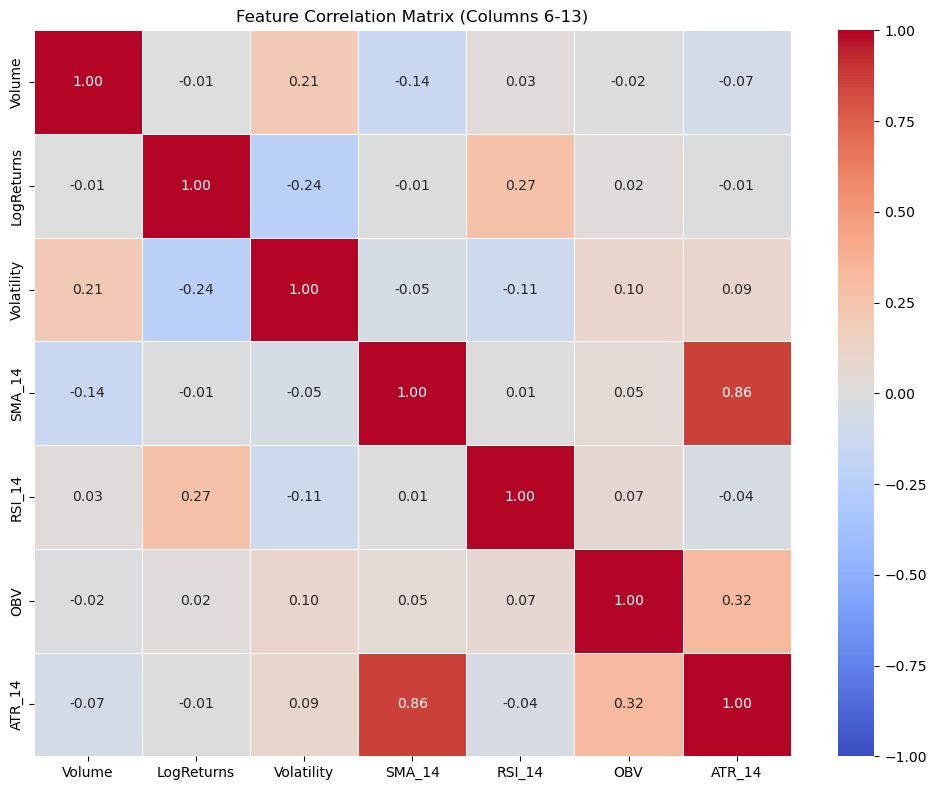

Selected columns: ['Volume', 'LogReturns', 'Volatility', 'SMA_14', 'RSI_14', 'OBV', 'ATR_14']


In [9]:
selected_columns = df_copy.iloc[:, 5:12]
correlation_matrix = selected_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix (Columns 6-13)')
plt.tight_layout()
plt.show()

print("Selected columns:", list(selected_columns.columns))

## 2. Model with hyperparameter tuning

Here, I also used 2 normal distributions to fit the mixture density model. 3 days of sequence. The train-validation-test split is now set to 70-15-15. Base on my manual tuning result the best model is in the following structure:

**Structure:**
- Input layer: Here we used 7 features With sequence Length of 3 time steps. Features per Time Step is 3 normalised features
- LSTM Layer: A single, stateless LSTM layer with a hidden dimension of 32.
- Hidden Layer 1: Here the first Hidden Layer is a fully connected (linear) layer that maps the 32-dimensional LSTM output to 32 neurons, then followed by an ELU activation function and applies dropout with a rate of 0.1.
- Hidden layer 2: Second Hidden Layer is also a fully connected layer mapping the 32 outputs from the first hidden layer to 32 neurons, followed again by an ELU activation function, and applies dropout with a rate of 0.1.
- Output Layers: Mu (Mean) Layer is A linear layer that maps the 32-dimensional output of the second hidden layer to a single value representing the predicted mean. And then a Sigma (Standard Deviation) Layer which is a linear layer mapping the same 32-dimensional vector to a single value, which is then exponentiated to ensure a positive standard deviation.

Still, the optimiser chosen was Adam.

Using manually selected hyperparameters:
{'lstm_hidden_dim': 32, 'n_hidden1': 32, 'n_hidden2': 32, 'lr': 0.005, 'dropout': 0.05, 'activation': 'elu'}
Epoch 100: Train NLL = -1.7448, Val NLL = -2.0204
Epoch 200: Train NLL = -1.8028, Val NLL = -2.1236
Epoch 300: Train NLL = -1.8517, Val NLL = -2.2290
Epoch 400: Train NLL = -1.8411, Val NLL = -2.2336
Early stopping at epoch 454
Test NLL: -1.9889


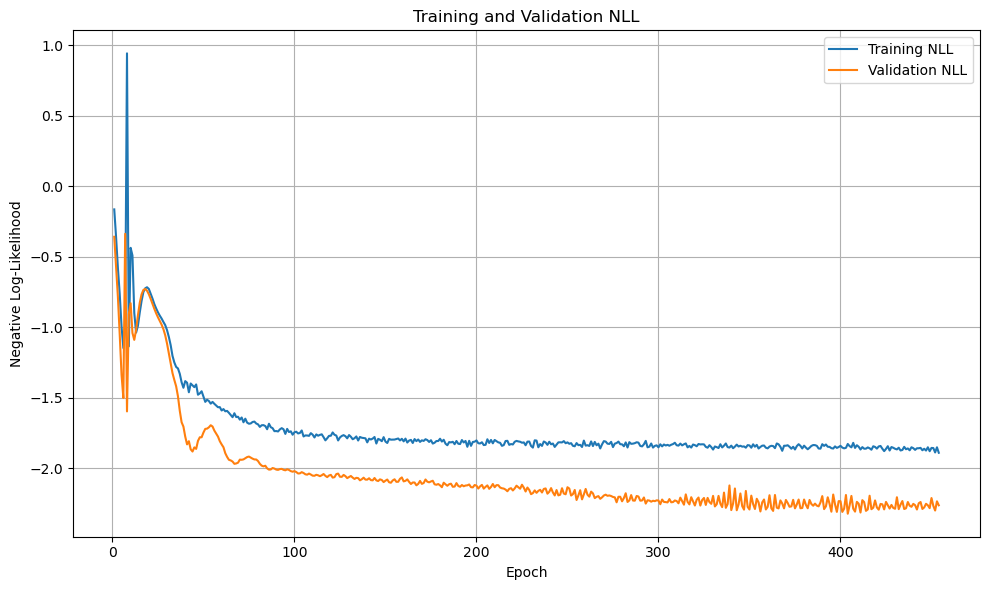

In [104]:
# -------------------------
# 1. Define model architecture with configurable activation and dropout
# -------------------------
class NormalDensityNetworkWithLSTM(nn.Module):
    def __init__(self, input_dim=3, seq_length=3, lstm_hidden_dim=16, 
                 n_hidden1=10, n_hidden2=10, dropout=0.0, activation="relu"):
        super().__init__()
        
        self.input_dim = input_dim        
        self.seq_length = seq_length     
        self.lstm_hidden_dim = lstm_hidden_dim  
        
        # LSTM layer - stateless LSTM
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=lstm_hidden_dim,
            batch_first=True,
            bidirectional=False
        )
        
        # Build first hidden layer: Linear -> Activation -> (Dropout, if > 0)
        layers_h1 = [nn.Linear(lstm_hidden_dim, n_hidden1)]
        if activation.lower() == "relu":
            layers_h1.append(nn.ReLU())
        elif activation.lower() == "leaky_relu":
            layers_h1.append(nn.LeakyReLU())
        elif activation.lower() == "elu":
            layers_h1.append(nn.ELU())
        else:
            layers_h1.append(nn.ReLU())
        if dropout > 0:
            layers_h1.append(nn.Dropout(dropout))
        self.hidden_layer1 = nn.Sequential(*layers_h1)
        
        # Build second hidden layer: Linear -> Activation -> (Dropout, if > 0)
        layers_h2 = [nn.Linear(n_hidden1, n_hidden2)]
        if activation.lower() == "relu":
            layers_h2.append(nn.ReLU())
        elif activation.lower() == "leaky_relu":
            layers_h2.append(nn.LeakyReLU())
        elif activation.lower() == "elu":
            layers_h2.append(nn.ELU())
        else:
            layers_h2.append(nn.ReLU())
        if dropout > 0:
            layers_h2.append(nn.Dropout(dropout))
        self.hidden_layer2 = nn.Sequential(*layers_h2)
        
        # Output layers for Gaussian parameters: mean and sigma
        self.mu_layer = nn.Linear(n_hidden2, 1)
        self.sigma_layer = nn.Linear(n_hidden2, 1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(1, batch_size, self.lstm_hidden_dim).to(x.device)
        c0 = torch.zeros(1, batch_size, self.lstm_hidden_dim).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_final = lstm_out[:, -1, :]
        hidden_output1 = self.hidden_layer1(lstm_final)
        hidden_output2 = self.hidden_layer2(hidden_output1)
        mu = self.mu_layer(hidden_output2)
        sigma = torch.exp(self.sigma_layer(hidden_output2))
        return mu, sigma

# -------------------------
# 2. Define Loss and Weight Initialization
# -------------------------
def gaussian_nll_loss(y, mu, sigma):
    normal_dist = torch.distributions.Normal(mu, sigma)
    nll = -normal_dist.log_prob(y)
    return nll.mean()

def init_weights(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            if param.dim() >= 2:
                nn.init.xavier_normal_(param)
            else:
                nn.init.ones_(param)
        elif 'bias' in name:
            nn.init.zeros_(param)
            if 'sigma_layer.bias' in name:
                nn.init.constant_(param, -1.0)

# -------------------------
# 3. Define the Final Training Function
# -------------------------
def train_final_model(X_train, y_train, X_val, y_val, X_test, y_test, config):
    model = NormalDensityNetworkWithLSTM(
        input_dim = X_train.shape[2],
        seq_length = X_train.shape[1],
        lstm_hidden_dim = config["lstm_hidden_dim"],
        n_hidden1 = config["n_hidden1"],
        n_hidden2 = config["n_hidden2"],
        dropout = config["dropout"],
        activation = config["activation"]
    )
    init_weights(model)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    
    num_epochs = 2000
    train_losses = []
    val_losses = []
    patience = 50
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        mu, sigma = model(X_train)
        loss_train = gaussian_nll_loss(y_train, mu, sigma)
        loss_train.backward()
        optimizer.step()
        train_losses.append(loss_train.item())
        
        model.eval()
        with torch.no_grad():
            mu_val, sigma_val = model(X_val)
            loss_val = gaussian_nll_loss(y_val, mu_val, sigma_val)
            val_losses.append(loss_val.item())
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}: Train NLL = {loss_train.item():.4f}, Val NLL = {loss_val.item():.4f}")
        
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        mu_test, sigma_test = model(X_test)
        test_loss = gaussian_nll_loss(y_test, mu_test, sigma_test)
    print(f"Test NLL: {test_loss.item():.4f}")
    
    return model, train_losses, val_losses

# -------------------------
# 4. Data Preparation
# -------------------------
# Ensure your dataset variables X_all and y_all (NumPy arrays) are defined.
train_size = int(len(X_all) * 0.7)
val_size = int(len(X_all) * 0.15)
test_size = len(X_all) - train_size - val_size

X_train_np = X_all[:train_size]
y_train_np = y_all[:train_size]
X_val_np = X_all[train_size:train_size+val_size]
y_val_np = y_all[train_size:train_size+val_size]
X_test_np = X_all[train_size+val_size:]
y_test_np = y_all[train_size+val_size:]

X_train = torch.FloatTensor(X_train_np)
y_train = torch.FloatTensor(y_train_np).unsqueeze(1)
X_val = torch.FloatTensor(X_val_np)
y_val = torch.FloatTensor(y_val_np).unsqueeze(1)
X_test = torch.FloatTensor(X_test_np)
y_test = torch.FloatTensor(y_test_np).unsqueeze(1)

# -------------------------
# 5. Manual Hyperparameter Selection (Best Model)
# -------------------------
manual_config = {
    "lstm_hidden_dim": 32,
    "n_hidden1": 32,
    "n_hidden2": 32,
    "lr": 0.005,
    "dropout": 0.05,
    "activation": "elu"
}
print("Using manually selected hyperparameters:")
print(manual_config)

# Train the model once with the selected hyperparameters.
model, train_losses, val_losses = train_final_model(X_train, y_train, X_val, y_val, X_test, y_test, manual_config)

# -------------------------
# 7. Plot the Training and Validation Losses
# -------------------------
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Training NLL')
plt.plot(epochs, val_losses, label='Validation NLL')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training and Validation NLL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Data date range: 2018-01-18 11:00:00 to 2025-03-31 11:00:00
Train: 1840 samples (2018-01-18 11:00:00 to 2023-01-31 11:00:00)
Val: 394 samples (2023-02-01 11:00:00 to 2024-02-29 11:00:00)
Test: 396 samples (2024-03-01 11:00:00 to 2025-03-31 11:00:00)


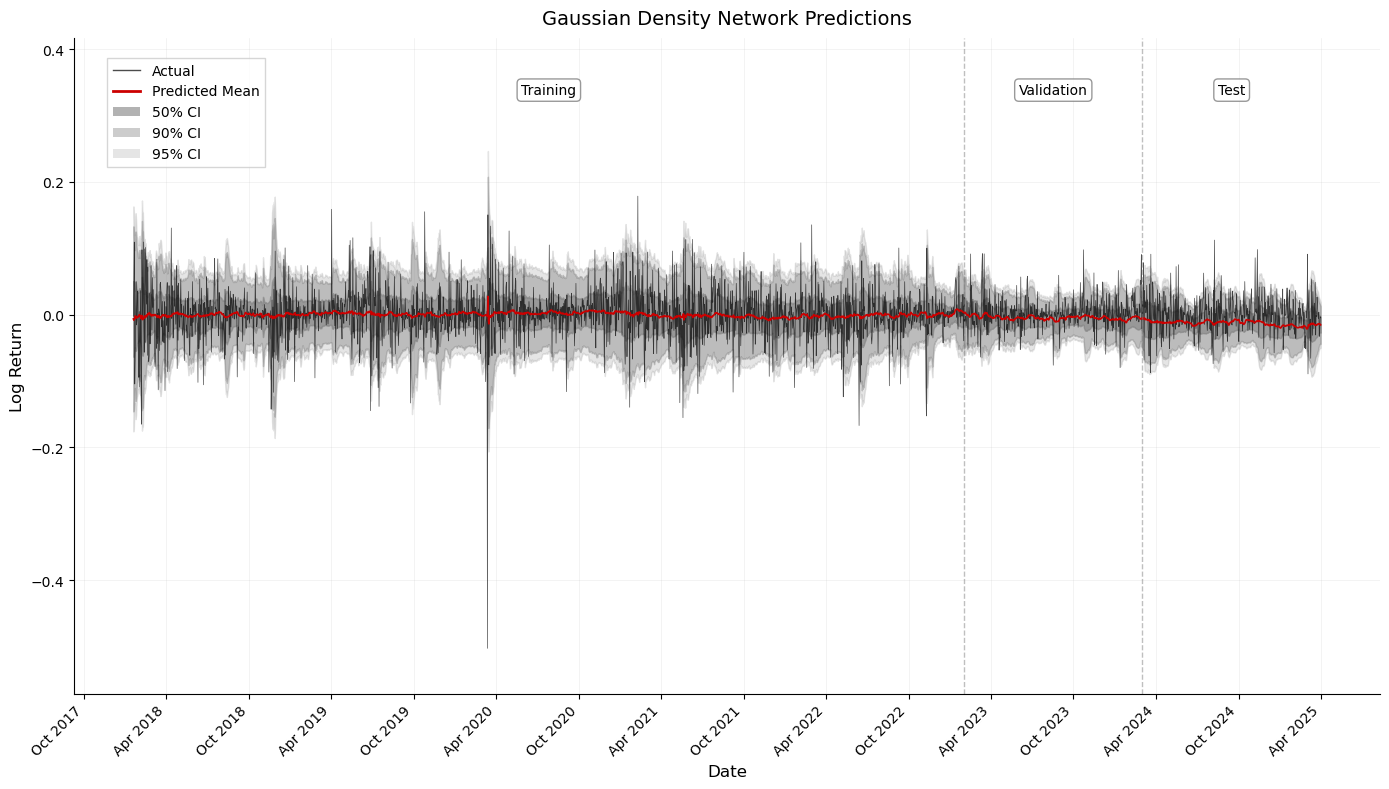

Full timeline plot saved as 'thesis_gaussian_timeline.png'


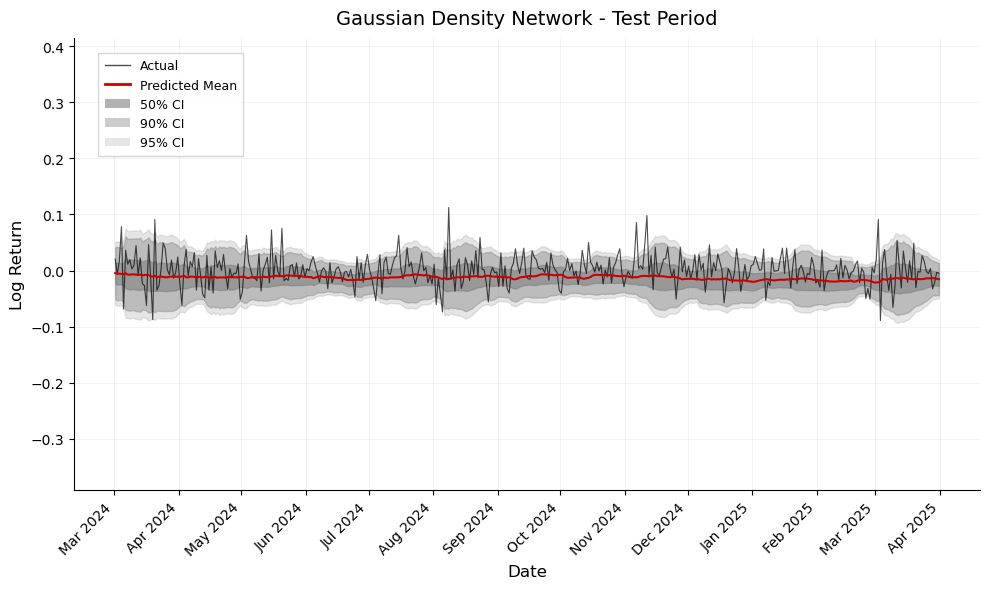

Test period plot saved as 'thesis_gaussian_testline.png'


In [106]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import torch
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# -----------------------------------------------
# 1. Get predictions from the trained model
# -----------------------------------------------
model.eval()
with torch.no_grad():
    train_mu, train_sigma = model(X_train)
    val_mu, val_sigma = model(X_val)
    test_mu, test_sigma = model(X_test)

# Convert predictions to NumPy arrays (move from GPU if necessary)
train_mu = train_mu.cpu().detach().numpy()
train_sigma = train_sigma.cpu().detach().numpy()
val_mu = val_mu.cpu().detach().numpy()
val_sigma = val_sigma.cpu().detach().numpy()
test_mu = test_mu.cpu().detach().numpy()
test_sigma = test_sigma.cpu().detach().numpy()

# Convert y values to numpy
y_train_np = y_train.cpu().numpy()
y_val_np = y_val.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# -----------------------------------------------
# 2. Get date indices from your data
# -----------------------------------------------
seq_length = 3  # Your sequence length
available_dates = df_copy['Date'].iloc[seq_length:].values

# Make sure we have the right number of dates
assert len(available_dates) == len(y_all), f"Date mismatch: {len(available_dates)} dates vs {len(y_all)} samples"

# Split the dates according to your train/val/test split
train_size = len(train_mu)
val_size = len(val_mu)
test_size = len(test_mu)

# Get the date arrays for each split
train_dates = available_dates[:train_size]
val_dates = available_dates[train_size:train_size + val_size]
test_dates = available_dates[train_size + val_size:train_size + val_size + test_size]

# Convert to pandas datetime if they aren't already
train_dates = pd.to_datetime(train_dates)
val_dates = pd.to_datetime(val_dates)
test_dates = pd.to_datetime(test_dates)

print(f"\nData date range: {train_dates[0]} to {test_dates[-1]}")
print(f"Train: {len(train_dates)} samples ({train_dates[0]} to {train_dates[-1]})")
print(f"Val: {len(val_dates)} samples ({val_dates[0]} to {val_dates[-1]})")
print(f"Test: {len(test_dates)} samples ({test_dates[0]} to {test_dates[-1]})")

# -----------------------------------------------
# 3. Plot 1: Full timeline predictions and confidence intervals
# -----------------------------------------------
fig, ax = plt.subplots(figsize=(14, 8))

# Define colors - using your thesis color scheme
actual_color = '#000000'  # Pure black for actual data
pred_color = '#CC0000'    # Red for predicted mean (matching your t-distribution plots)
ci_color = '#808080'      # Gray for confidence intervals

# Extend y-axis limits to make room for legend
y_min = min(y_train_np.min(), y_val_np.min(), y_test_np.min())
y_max = max(y_train_np.max(), y_val_np.max(), y_test_np.max())
y_range = y_max - y_min
ax.set_ylim(y_min - 0.1*y_range, y_max + 0.35*y_range)

# ---------- Train ----------
ax.plot(train_dates, y_train_np, color=actual_color, alpha=0.7, linewidth=0.5, label='Actual')
ax.plot(train_dates, train_mu, color=pred_color, linewidth=1.2, label='Predicted Mean')
ax.fill_between(train_dates, 
                train_mu.flatten() - 2 * train_sigma.flatten(), 
                train_mu.flatten() + 2 * train_sigma.flatten(), 
                color=ci_color, alpha=0.2)
ax.fill_between(train_dates, 
                train_mu.flatten() - 1.645 * train_sigma.flatten(), 
                train_mu.flatten() + 1.645 * train_sigma.flatten(), 
                color=ci_color, alpha=0.4)
ax.fill_between(train_dates, 
                train_mu.flatten() - 0.674 * train_sigma.flatten(), 
                train_mu.flatten() + 0.674 * train_sigma.flatten(), 
                color=ci_color, alpha=0.6)

# ---------- Validation ----------
ax.plot(val_dates, y_val_np, color=actual_color, alpha=0.7, linewidth=0.5)
ax.plot(val_dates, val_mu, color=pred_color, linewidth=1.2)
ax.fill_between(val_dates, 
                val_mu.flatten() - 2 * val_sigma.flatten(), 
                val_mu.flatten() + 2 * val_sigma.flatten(), 
                color=ci_color, alpha=0.2)
ax.fill_between(val_dates, 
                val_mu.flatten() - 1.645 * val_sigma.flatten(), 
                val_mu.flatten() + 1.645 * val_sigma.flatten(), 
                color=ci_color, alpha=0.4)
ax.fill_between(val_dates, 
                val_mu.flatten() - 0.674 * val_sigma.flatten(), 
                val_mu.flatten() + 0.674 * val_sigma.flatten(), 
                color=ci_color, alpha=0.6)

# ---------- Test ----------
ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.5)
ax.plot(test_dates, test_mu, color=pred_color, linewidth=1.2)
ax.fill_between(test_dates, 
                test_mu.flatten() - 2 * test_sigma.flatten(), 
                test_mu.flatten() + 2 * test_sigma.flatten(), 
                color=ci_color, alpha=0.2)
ax.fill_between(test_dates, 
                test_mu.flatten() - 1.645 * test_sigma.flatten(), 
                test_mu.flatten() + 1.645 * test_sigma.flatten(), 
                color=ci_color, alpha=0.4)
ax.fill_between(test_dates, 
                test_mu.flatten() - 0.674 * test_sigma.flatten(), 
                test_mu.flatten() + 0.674 * test_sigma.flatten(), 
                color=ci_color, alpha=0.6)

# ---------- Add vertical lines at split points ----------
ax.axvline(x=train_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(x=val_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)

# ---------- Add period labels ----------
train_mid = train_dates[len(train_dates)//2]
val_mid = val_dates[len(val_dates)//2]
test_mid = test_dates[len(test_dates)//2]

# Add text labels for each period
y_position = y_max + 0.25*y_range
ax.text(train_mid, y_position, 'Training', ha='center', va='top', fontsize=10, 
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
ax.text(val_mid, y_position, 'Validation', ha='center', va='top', fontsize=10,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
ax.text(test_mid, y_position, 'Test', ha='center', va='top', fontsize=10,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))

# ---------- Format x-axis ----------
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Changed to abbreviated month format
plt.xticks(rotation=45, ha='right')

# Set appropriate date locator
date_range_days = (test_dates[-1] - train_dates[0]).days
if date_range_days > 365 * 2:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
elif date_range_days > 365:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
else:
    ax.xaxis.set_major_locator(mdates.MonthLocator())

# ---------- Create custom legend ----------
legend_elements = [
    Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
    Line2D([0], [0], color=pred_color, lw=2, label='Predicted Mean'),
    Patch(facecolor=ci_color, alpha=0.6, label='50% CI'),
    Patch(facecolor=ci_color, alpha=0.4, label='90% CI'),
    Patch(facecolor=ci_color, alpha=0.2, label='95% CI')
]

# Place legend inside the plot at upper left
ax.legend(handles=legend_elements, loc='upper left', 
          frameon=True, fancybox=False, shadow=False, ncol=1, fontsize=10,
          bbox_to_anchor=(0.02, 0.98))

# ---------- Final formatting ----------
ax.set_title('Gaussian Density Network Predictions', fontsize=14, pad=10)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Log Return', fontsize=12)
ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.tight_layout()
plt.savefig('thesis_gaussian_timeline.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Full timeline plot saved as 'thesis_gaussian_timeline.png'")

# -----------------------------------------------
# 4. Plot 2: Zoomed-in plot for test period
# -----------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Extend y-axis for test period
y_min_test = y_test_np.min()
y_max_test = y_test_np.max()
y_range_test = y_max_test - y_min_test
ax.set_ylim(y_min_test - 1.5*y_range_test, y_max_test + 1.5*y_range_test)

# Plot with same color scheme
ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.8, label='Actual')
ax.plot(test_dates, test_mu, color=pred_color, linewidth=1.5, label='Predicted Mean')
ax.fill_between(test_dates, 
                test_mu.flatten() - 2 * test_sigma.flatten(),
                test_mu.flatten() + 2 * test_sigma.flatten(), 
                color=ci_color, alpha=0.2, label='95% CI')
ax.fill_between(test_dates, 
                test_mu.flatten() - 1.645 * test_sigma.flatten(),
                test_mu.flatten() + 1.645 * test_sigma.flatten(), 
                color=ci_color, alpha=0.4, label='90% CI')
ax.fill_between(test_dates, 
                test_mu.flatten() - 0.674 * test_sigma.flatten(),
                test_mu.flatten() + 0.674 * test_sigma.flatten(), 
                color=ci_color, alpha=0.6, label='50% CI')

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')

# Reduce number of date labels for test period
test_range_days = (test_dates[-1] - test_dates[0]).days
if test_range_days > 180:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
elif test_range_days > 60:
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
elif test_range_days > 30:
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
elif test_range_days > 14:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
else:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))

# Legend inside with spacing parameters
legend_elements = [
    Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
    Line2D([0], [0], color=pred_color, lw=2, label='Predicted Mean'),
    Patch(facecolor=ci_color, alpha=0.6, label='50% CI'),
    Patch(facecolor=ci_color, alpha=0.4, label='90% CI'),
    Patch(facecolor=ci_color, alpha=0.2, label='95% CI')
]

ax.legend(handles=legend_elements, loc='upper left',
          frameon=True, fancybox=False, shadow=False, ncol=1,
          bbox_to_anchor=(0.02, 0.98),
          prop={'size': 9},
          borderpad=0.5,
          columnspacing=1.0,
          handlelength=2.0,
          handletextpad=0.8,
          labelspacing=0.5)

ax.set_title('Gaussian Density Network - Test Period', fontsize=14, pad=10)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Log Return', fontsize=12)
ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.tight_layout()
plt.savefig('thesis_gaussian_testline.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Test period plot saved as 'thesis_gaussian_testline.png'")

Initial price: $10,988.79


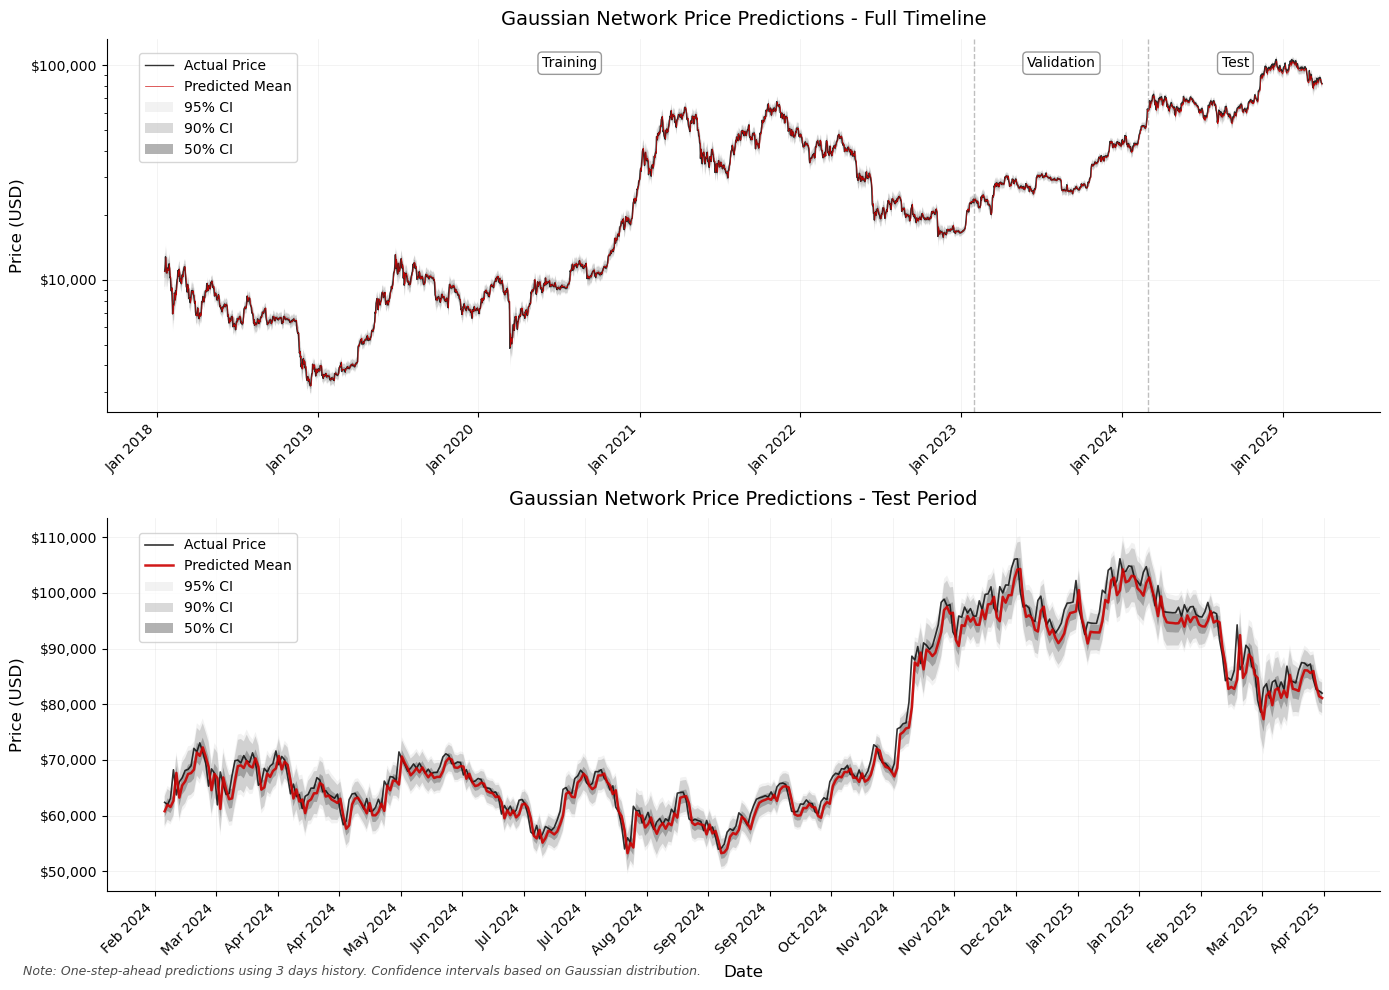

Plot saved as 'thesis_gaussian_price_predictions.png'

Price Statistics:
Final actual price: $82,002.02
Final predicted mean price: $81,126.21
Final 95% CI: $77,935.62 - $84,447.42

Test Period Metrics (Log Returns):
RMSE: 0.031061
MAE: 0.023728
Mean σ: 0.027353


In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_gaussian_price_predictions(model, X_train, X_val, X_test, 
                                   y_train, y_val, y_test,
                                   df_copy, seq_length=3,
                                   confidence_levels=[0.5, 0.9, 0.95],
                                   save_path='thesis_gaussian_price_predictions.png'):
    """
    Convert Gaussian network log return predictions to price predictions.
    Shows one-step-ahead predictions converted to prices.
    """
    
    # Get model predictions
    model.eval()
    with torch.no_grad():
        train_mu, train_sigma = model(X_train)
        val_mu, val_sigma = model(X_val)
        test_mu, test_sigma = model(X_test)
    
    # Convert to numpy
    train_mu = train_mu.cpu().numpy().flatten()
    train_sigma = train_sigma.cpu().numpy().flatten()
    val_mu = val_mu.cpu().numpy().flatten()
    val_sigma = val_sigma.cpu().numpy().flatten()
    test_mu = test_mu.cpu().numpy().flatten()
    test_sigma = test_sigma.cpu().numpy().flatten()
    
    # Combine all predictions
    all_mu = np.concatenate([train_mu, val_mu, test_mu])
    all_sigma = np.concatenate([train_sigma, val_sigma, test_sigma])
    
    # Combine all actual values
    y_train_np = y_train.cpu().numpy().flatten()
    y_val_np = y_val.cpu().numpy().flatten()
    y_test_np = y_test.cpu().numpy().flatten()
    y_all = np.concatenate([y_train_np, y_val_np, y_test_np])
    
    # Get dates
    available_dates = df_copy['Date'].iloc[seq_length:seq_length+len(y_all)].values
    available_dates = pd.to_datetime(available_dates)
    
    # Split dates
    train_size = len(train_mu)
    val_size = len(val_mu)
    test_size = len(test_mu)
    
    train_dates = available_dates[:train_size]
    val_dates = available_dates[train_size:train_size+val_size]
    test_dates = available_dates[train_size+val_size:]
    
    # Get initial price
    if 'Close' in df_copy.columns:
        initial_price = df_copy['Close'].iloc[seq_length-1]
    else:
        initial_price = 50000  # Default Bitcoin price if not available
    
    print(f"Initial price: ${initial_price:,.2f}")
    
    # Convert actual log returns to prices
    actual_prices = np.zeros(len(y_all))
    actual_prices[0] = initial_price * np.exp(y_all[0])
    for i in range(1, len(y_all)):
        actual_prices[i] = actual_prices[i-1] * np.exp(y_all[i])
    
    # Calculate price predictions for different confidence levels
    price_bands = {}
    
    # Mean prediction (best estimate)
    mean_prices = np.zeros(len(all_mu))
    mean_prices[0] = initial_price * np.exp(all_mu[0])
    for i in range(1, len(all_mu)):
        mean_prices[i] = actual_prices[i-1] * np.exp(all_mu[i])
    
    # Calculate confidence bands
    from scipy.stats import norm
    
    for conf_level in confidence_levels:
        alpha = 1 - conf_level
        z_score = norm.ppf(1 - alpha/2)
        
        # Upper and lower bounds for log returns
        upper_log_returns = all_mu + z_score * all_sigma
        lower_log_returns = all_mu - z_score * all_sigma
        
        # Convert to prices
        upper_prices = np.zeros(len(all_mu))
        lower_prices = np.zeros(len(all_mu))
        
        upper_prices[0] = initial_price * np.exp(upper_log_returns[0])
        lower_prices[0] = initial_price * np.exp(lower_log_returns[0])
        
        for i in range(1, len(all_mu)):
            upper_prices[i] = actual_prices[i-1] * np.exp(upper_log_returns[i])
            lower_prices[i] = actual_prices[i-1] * np.exp(lower_log_returns[i])
        
        price_bands[conf_level] = {'upper': upper_prices, 'lower': lower_prices}
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Color scheme - matching your thesis style
    actual_color = '#000000'  # Black for actual
    pred_color = '#CC0000'    # Red for predictions
    band_colors = {
        0.95: '#c0c0c0',  # Light gray for 95% CI
        0.9: '#a0a0a0',   # Medium gray for 90% CI
        0.5: '#808080'    # Dark gray for 50% CI
    }
    
    # ---------- Panel 1: Full Timeline ----------
    ax1.plot(available_dates, actual_prices, color=actual_color, 
             alpha=0.8, linewidth=1.0, label='Actual Price')
    ax1.plot(available_dates, mean_prices, color=pred_color, 
             linewidth=0.5, label='Predicted Mean', alpha=0.9)
    
    # Plot confidence bands from widest to narrowest
    for conf_level in [0.95, 0.9, 0.5]:
        if conf_level in price_bands:
            alpha_val = 0.2 if conf_level == 0.95 else (0.4 if conf_level == 0.9 else 0.6)
            ax1.fill_between(available_dates,
                            price_bands[conf_level]['lower'],
                            price_bands[conf_level]['upper'],
                            color=band_colors[conf_level],
                            alpha=alpha_val,
                            label=f'{int(conf_level*100)}% CI',
                            edgecolor='none')
    
    # Add vertical lines for splits
    ax1.axvline(x=train_dates[-1], color='gray', linestyle='--', 
                alpha=0.5, linewidth=1)
    ax1.axvline(x=val_dates[-1], color='gray', linestyle='--', 
                alpha=0.5, linewidth=1)
    
    # Add period labels
    train_mid = train_dates[len(train_dates)//2]
    val_mid = val_dates[len(val_dates)//2]
    test_mid = test_dates[len(test_dates)//2]
    
    y_max = ax1.get_ylim()[1]
    label_y = y_max * 0.95
    
    ax1.text(train_mid, label_y, 'Training', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    ax1.text(val_mid, label_y, 'Validation', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    ax1.text(test_mid, label_y, 'Test', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    
    # Formatting
    ax1.set_title('Gaussian Network Price Predictions - Full Timeline', 
                  fontsize=14, pad=10)
    ax1.set_ylabel('Price (USD)', fontsize=12)
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Legend
    ax1.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    # Remove spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # ---------- Panel 2: Test Period ----------
    test_start_idx = train_size + val_size
    test_actual = actual_prices[test_start_idx:]
    test_mean = mean_prices[test_start_idx:]
    
    ax2.plot(test_dates, test_actual, color=actual_color, 
             alpha=0.8, linewidth=1.2, label='Actual Price')
    ax2.plot(test_dates, test_mean, color=pred_color, 
             linewidth=1.8, label='Predicted Mean', alpha=0.9)
    
    # Plot confidence bands
    for conf_level in [0.95, 0.9, 0.5]:
        if conf_level in price_bands:
            alpha_val = 0.2 if conf_level == 0.95 else (0.4 if conf_level == 0.9 else 0.6)
            ax2.fill_between(test_dates,
                            price_bands[conf_level]['lower'][test_start_idx:],
                            price_bands[conf_level]['upper'][test_start_idx:],
                            color=band_colors[conf_level],
                            alpha=alpha_val,
                            label=f'{int(conf_level*100)}% CI',
                            edgecolor='none')
    
    # Formatting
    ax2.set_title('Gaussian Network Price Predictions - Test Period', 
                  fontsize=14, pad=10)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Price (USD)', fontsize=12)
    ax2.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Reduce date labels
    test_range_days = (test_dates[-1] - test_dates[0]).days
    if test_range_days > 60:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_range_days > 30:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    else:
        ax2.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    
    # Legend
    ax2.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    # Remove spines
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Add note
    fig.text(0.02, 0.02, 
             f'Note: One-step-ahead predictions using {seq_length} days history. ' + 
             'Confidence intervals based on Gaussian distribution.',
             transform=fig.transFigure, fontsize=9, style='italic', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Save as separate plots
    # Plot 1: Full Timeline
    fig1, ax1 = plt.subplots(figsize=(14, 8))
    
    ax1.plot(available_dates, actual_prices, color=actual_color, 
             alpha=0.8, linewidth=1.0, label='Actual Price')
    ax1.plot(available_dates, mean_prices, color=pred_color, 
             linewidth=0.5, label='Predicted Mean', alpha=0.9)
    
    for conf_level in [0.95, 0.9, 0.5]:
        if conf_level in price_bands:
            alpha_val = 0.4 if conf_level == 0.95 else (0.6 if conf_level == 0.9 else 0.8)
            ax1.fill_between(available_dates,
                            price_bands[conf_level]['lower'],
                            price_bands[conf_level]['upper'],
                            color=band_colors[conf_level],
                            alpha=alpha_val,
                            label=f'{int(conf_level*100)}% CI',
                            edgecolor='none')
    
    ax1.axvline(x=train_dates[-1], color='gray', linestyle='--', 
                alpha=0.5, linewidth=1)
    ax1.axvline(x=val_dates[-1], color='gray', linestyle='--', 
                alpha=0.5, linewidth=1)
    
    y_max = ax1.get_ylim()[1]
    label_y = y_max * 0.95
    
    ax1.text(train_mid, label_y, 'Training', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    ax1.text(val_mid, label_y, 'Validation', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    ax1.text(test_mid, label_y, 'Test', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    
    ax1.set_title('Gaussian Network Price Predictions', 
                  fontsize=14, pad=10)
    ax1.set_ylabel('Price (USD)', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax1.set_axisbelow(True)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    ax1.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('thesis_gaussian_price_timeline.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot 2: Test Period
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    
    ax2.plot(test_dates, test_actual, color=actual_color, 
             alpha=0.8, linewidth=1.5, label='Actual Price')
    ax2.plot(test_dates, test_mean, color=pred_color, 
             linewidth=0.8, label='Predicted Mean', alpha=0.9)
    
    for conf_level in [0.95, 0.9, 0.5]:
        if conf_level in price_bands:
            alpha_val = 0.4 if conf_level == 0.95 else (0.6 if conf_level == 0.9 else 0.8)
            ax2.fill_between(test_dates,
                            price_bands[conf_level]['lower'][test_start_idx:],
                            price_bands[conf_level]['upper'][test_start_idx:],
                            color=band_colors[conf_level],
                            alpha=alpha_val,
                            label=f'{int(conf_level*100)}% CI',
                            edgecolor='none')
    
    ax2.set_title('Gaussian Network Price Predictions - Test Period', 
                  fontsize=14, pad=10)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Price (USD)', fontsize=12)
    ax2.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax2.set_axisbelow(True)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    test_range_days = (test_dates[-1] - test_dates[0]).days
    if test_range_days > 60:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_range_days > 30:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    else:
        ax2.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    
    ax2.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('thesis_gaussian_price_testline.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Plot saved as '{save_path}'")
    
    # Print statistics
    print(f"\nPrice Statistics:")
    print(f"Final actual price: ${actual_prices[-1]:,.2f}")
    print(f"Final predicted mean price: ${mean_prices[-1]:,.2f}")
    print(f"Final 95% CI: ${price_bands[0.95]['lower'][-1]:,.2f} - ${price_bands[0.95]['upper'][-1]:,.2f}")
    
    # Calculate prediction accuracy metrics
    test_actual_log = y_test_np
    test_pred_log = test_mu
    rmse = np.sqrt(np.mean((test_actual_log - test_pred_log)**2))
    mae = np.mean(np.abs(test_actual_log - test_pred_log))
    
    print(f"\nTest Period Metrics (Log Returns):")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"Mean σ: {np.mean(test_sigma):.6f}")
    
    return fig, actual_prices, mean_prices, price_bands
# Usage example:
fig, actual_prices, mean_prices, price_bands = plot_gaussian_price_predictions(
     model=model,
     X_train=X_train, X_val=X_val, X_test=X_test,
     y_train=y_train, y_val=y_val, y_test=y_test,
     df_copy=df_copy,
     seq_length=3,
     confidence_levels=[0.5, 0.9, 0.95],
     save_path='thesis_gaussian_price_predictions.png'
)

## 3. Best model with 10 times repeatition

I then model the data with 10 repetitions—each repetition involves reinitializing and training the identical model configuration (using 32 neurons in each hidden layer with a dropout rate of 0.1 and ELU activation, optimised with Adam at a learning rate of 0.005) from scratch, using a different random seed for each run. For each run, I record training, validation, and test metrics (MAE, MSE, and negative log-likelihood) as well as the test-set predictions (the fitted line) and loss curves. 

Using manually selected hyperparameters:
{'lstm_hidden_dim': 32, 'n_hidden1': 32, 'n_hidden2': 32, 'lr': 0.005, 'dropout': 0.1, 'activation': 'elu'}

=== Run 1/15 ===
Epoch 100: Train Loss = -1.7545, Val Loss = -2.0236
Epoch 200: Train Loss = -1.8401, Val Loss = -2.2705
Epoch 300: Train Loss = -1.8553, Val Loss = -2.2232
Early stopping at epoch 316
Test Loss: -1.9482
Run 1 Metrics:
  Train: MAE = 0.0263, MSE = 0.0015, NLL = -1.8794
  Val:   MAE = 0.0182, MSE = 0.0007, NLL = -2.2208
  Test:  MAE = 0.0250, MSE = 0.0010, NLL = -1.9482

=== Run 2/15 ===
Epoch 100: Train Loss = -1.7785, Val Loss = -2.1409
Epoch 200: Train Loss = -1.8199, Val Loss = -2.2633
Early stopping at epoch 222
Test Loss: -2.0379
Run 2 Metrics:
  Train: MAE = 0.0261, MSE = 0.0015, NLL = -1.8638
  Val:   MAE = 0.0171, MSE = 0.0006, NLL = -2.2705
  Test:  MAE = 0.0223, MSE = 0.0009, NLL = -2.0379

=== Run 3/15 ===
Epoch 100: Train Loss = -1.8047, Val Loss = -2.1249
Epoch 200: Train Loss = -1.8402, Val Loss = -2.2813
Ear

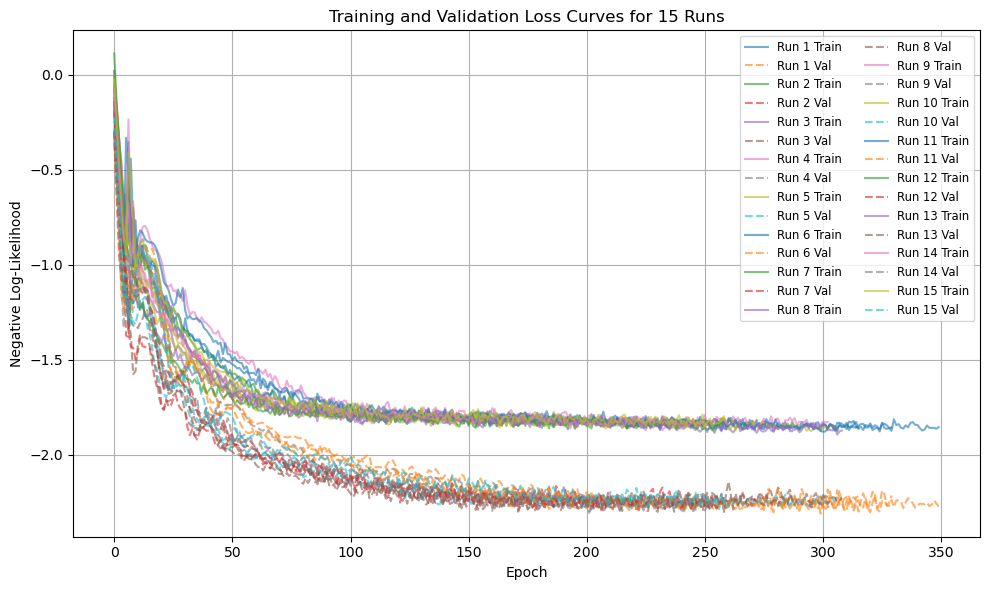


Best run is Run 6 with validation NLL = -2.2740


In [124]:
# -------------------------
# 1. Define model architecture with configurable activation and dropout
# -------------------------
class NormalDensityNetworkWithLSTM(nn.Module):
    def __init__(self, input_dim=3, seq_length=3, lstm_hidden_dim=16, 
                 n_hidden1=32, n_hidden2=32, dropout=0.1, activation="relu"):
        super().__init__()
        
        self.input_dim = input_dim        
        self.seq_length = seq_length     
        self.lstm_hidden_dim = lstm_hidden_dim  
        
        # LSTM layer - stateless LSTM
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=lstm_hidden_dim,
            batch_first=True,
            bidirectional=False
        )
        
        # Build first hidden layer: Linear -> Activation -> (Dropout, if > 0)
        layers_h1 = [nn.Linear(lstm_hidden_dim, n_hidden1)]
        if activation.lower() == "relu":
            layers_h1.append(nn.ReLU())
        elif activation.lower() == "leaky_relu":
            layers_h1.append(nn.LeakyReLU())
        elif activation.lower() == "elu":
            layers_h1.append(nn.ELU())
        else:
            layers_h1.append(nn.ReLU())
        if dropout > 0:
            layers_h1.append(nn.Dropout(dropout))
        self.hidden_layer1 = nn.Sequential(*layers_h1)
        
        # Build second hidden layer: Linear -> Activation -> (Dropout, if > 0)
        layers_h2 = [nn.Linear(n_hidden1, n_hidden2)]
        if activation.lower() == "relu":
            layers_h2.append(nn.ReLU())
        elif activation.lower() == "leaky_relu":
            layers_h2.append(nn.LeakyReLU())
        elif activation.lower() == "elu":
            layers_h2.append(nn.ELU())
        else:
            layers_h2.append(nn.ReLU())
        if dropout > 0:
            layers_h2.append(nn.Dropout(dropout))
        self.hidden_layer2 = nn.Sequential(*layers_h2)
        
        # Output layers for Gaussian parameters: mean and sigma
        self.mu_layer = nn.Linear(n_hidden2, 1)
        self.sigma_layer = nn.Linear(n_hidden2, 1)
        
    def forward(self, x):
        # x shape: [batch_size, seq_length, input_dim]
        batch_size = x.shape[0]
        
        # Initialize hidden and cell states (stateless: reinitialize every forward pass)
        h0 = torch.zeros(1, batch_size, self.lstm_hidden_dim).to(x.device)
        c0 = torch.zeros(1, batch_size, self.lstm_hidden_dim).to(x.device)
        
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_final = lstm_out[:, -1, :]
        
        hidden_output1 = self.hidden_layer1(lstm_final)
        hidden_output2 = self.hidden_layer2(hidden_output1)
        
        mu = self.mu_layer(hidden_output2)
        sigma = torch.exp(self.sigma_layer(hidden_output2))  # ensures sigma > 0
        
        return mu, sigma

# -------------------------
# 2. Define Loss and Weight Initialization
# -------------------------
def gaussian_nll_loss(y, mu, sigma):
    normal_dist = torch.distributions.Normal(mu, sigma)
    nll = -normal_dist.log_prob(y)
    return nll.mean()

def init_weights(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            if param.dim() >= 2:
                nn.init.xavier_normal_(param)
            else:
                nn.init.ones_(param)
        elif 'bias' in name:
            nn.init.zeros_(param)
            if 'sigma_layer.bias' in name:
                nn.init.constant_(param, -1.0)

# -------------------------
# 3. Define the Final Training Function
# -------------------------
def train_final_model(X_train, y_train, X_val, y_val, X_test, y_test, config):
    """
    Trains the model using the specified hyperparameters.
    Performs full training with early stopping and evaluates on the test set.
    Returns the trained model, training loss curve, and validation loss curve.
    """
    model = NormalDensityNetworkWithLSTM(
        input_dim=X_train.shape[2],
        seq_length=X_train.shape[1],
        lstm_hidden_dim=config["lstm_hidden_dim"],
        n_hidden1=config["n_hidden1"],
        n_hidden2=config["n_hidden2"],
        dropout=config["dropout"],
        activation=config["activation"]
    )
    init_weights(model)
    
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    
    num_epochs = 2000
    train_losses = []
    val_losses = []
    patience = 50
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        mu, sigma = model(X_train)
        loss_train = gaussian_nll_loss(y_train, mu, sigma)
        loss_train.backward()
        optimizer.step()
        train_losses.append(loss_train.item())
        
        model.eval()
        with torch.no_grad():
            mu_val, sigma_val = model(X_val)
            loss_val = gaussian_nll_loss(y_val, mu_val, sigma_val)
            val_losses.append(loss_val.item())
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}: Train Loss = {loss_train.item():.4f}, Val Loss = {loss_val.item():.4f}")
        
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        mu_test, sigma_test = model(X_test)
        test_loss = gaussian_nll_loss(y_test, mu_test, sigma_test)
    print(f"Test Loss: {test_loss.item():.4f}")
    
    return model, train_losses, val_losses


# -------------------------
# 5. Manual Hyperparameter Selection (Best Model) and 10 Repeat Runs
# -------------------------
manual_config = {
    "lstm_hidden_dim": 32,
    "n_hidden1": 32,
    "n_hidden2": 32,
    "lr": 0.005,
    "dropout": 0.1,         # Try different dropout rates here if desired
    "activation": "elu"     # Try "relu", "leaky_relu", or "elu"
}
print("Using manually selected hyperparameters:")
print(manual_config)

num_runs = 15
all_run_metrics = []      # List to store metrics for each run: (train_metrics, val_metrics, test_metrics)
all_run_predictions = []  # List to store test-set predictions for each run
all_run_losses = []       # List to store the loss curves for each run
all_run_sigmas = [] 

# Define a helper function to compute metrics
def compute_metrics(y_true, mu, sigma):
    mae = torch.mean(torch.abs(y_true - mu)).item()
    mse = torch.mean((y_true - mu)**2).item()
    nll = gaussian_nll_loss(y_true, mu, sigma).item()
    return mae, mse, nll

for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} ===")
    seed = run + 1
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model, train_losses, val_losses = train_final_model(X_train, y_train, X_val, y_val, X_test, y_test, manual_config)
    
    model.eval()
    with torch.no_grad():
        mu_train, sigma_train = model(X_train)
        mu_val, sigma_val = model(X_val)
        mu_test, sigma_test = model(X_test)
    
    metrics_train = compute_metrics(y_train, mu_train, sigma_train)
    metrics_val = compute_metrics(y_val, mu_val, sigma_val)
    metrics_test = compute_metrics(y_test, mu_test, sigma_test)
    
    print(f"Run {run+1} Metrics:")
    print(f"  Train: MAE = {metrics_train[0]:.4f}, MSE = {metrics_train[1]:.4f}, NLL = {metrics_train[2]:.4f}")
    print(f"  Val:   MAE = {metrics_val[0]:.4f}, MSE = {metrics_val[1]:.4f}, NLL = {metrics_val[2]:.4f}")
    print(f"  Test:  MAE = {metrics_test[0]:.4f}, MSE = {metrics_test[1]:.4f}, NLL = {metrics_test[2]:.4f}")
    
    all_run_metrics.append((metrics_train, metrics_val, metrics_test))
    all_run_predictions.append(mu_test.cpu().numpy())
    all_run_losses.append((train_losses, val_losses))
    all_run_sigmas.append(sigma_test.cpu().numpy())

# -------------------------
# 6. Optionally, plot training & validation losses for each run (or average over runs)
# -------------------------
plt.figure(figsize=(10, 6))
for i, (train_loss_curve, val_loss_curve) in enumerate(all_run_losses):
    plt.plot(train_loss_curve, label=f'Run {i+1} Train', alpha=0.6)
    plt.plot(val_loss_curve, label=f'Run {i+1} Val', linestyle='--', alpha=0.6)
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("Training and Validation Loss Curves for 15 Runs")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# 7. Select the Best Run Based on Validation NLL
# -------------------------
best_run_idx = None
best_val_nll = float('inf')
for idx, metrics in enumerate(all_run_metrics):
    val_nll = metrics[1][2]  # metrics[1] are validation metrics; index 2 is NLL
    if val_nll < best_val_nll:
        best_val_nll = val_nll
        best_run_idx = idx

print(f"\nBest run is Run {best_run_idx+1} with validation NLL = {best_val_nll:.4f}")



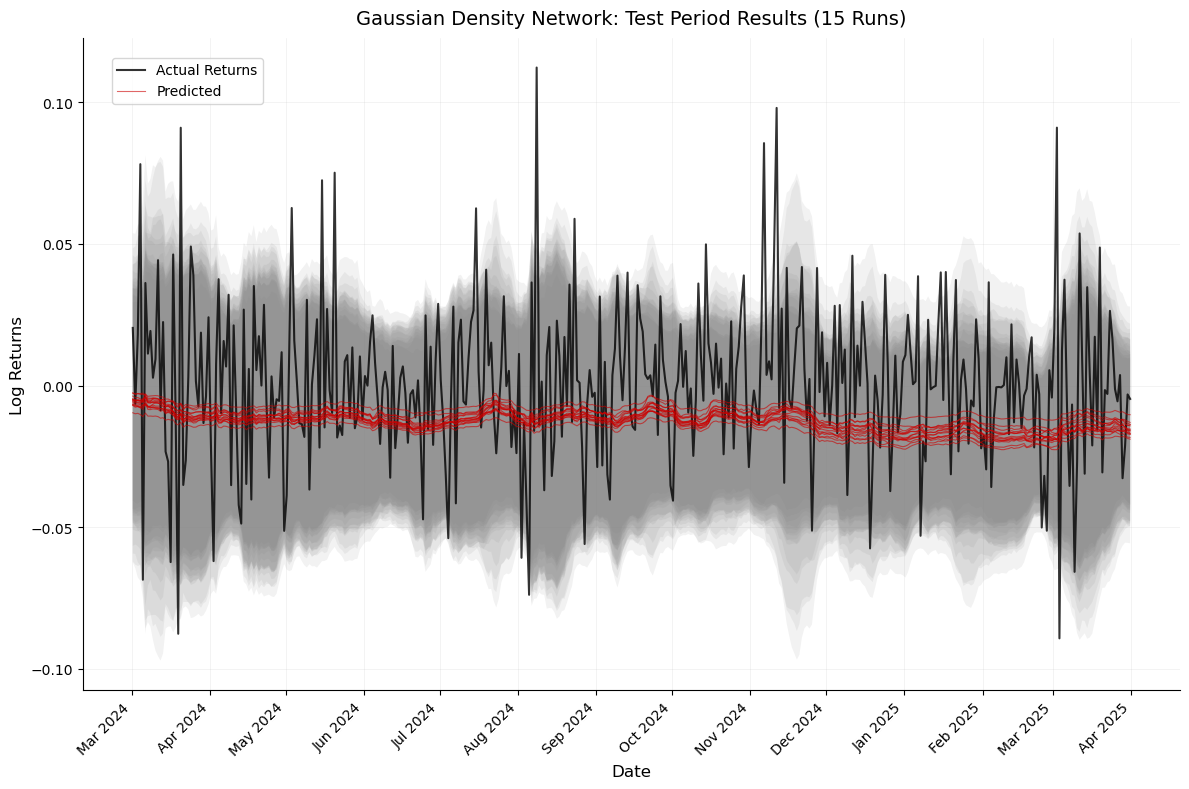

In [130]:

# Get dates for test period
# -------------------------
# Extract dates from df_copy for test period alignment
seq_length = 3
total_sequences = len(X_all)
train_size = int(total_sequences * 0.7)  # 1841
val_size = int(total_sequences * 0.15)   # 394
test_start_sequence_idx = train_size + val_size  # Start of test set

first_sequence_original_row = seq_length

# Get dates for test period
test_dates_list = []
for j in range(len(y_test)):
    sequence_idx = test_start_sequence_idx + j
    target_day_in_df = first_sequence_original_row + sequence_idx
    
    if target_day_in_df < len(df_copy):
        test_dates_list.append(df_copy.iloc[target_day_in_df]['Date'])
    else:
        test_dates_list.append(pd.NaT)

test_dates = pd.to_datetime(test_dates_list)

# Define number of runs
num_runs = 15

# Define number of runs
num_runs = 15

# -------------------------
# Get dates for test period using your standard split
# -------------------------
seq_length = 3
n_all = len(y_all)
train_size = 0.7
val_size = 0.15

train_end = int(n_all * train_size)
val_end = train_end + int(n_all * val_size)
test_start_idx = val_end

# Get all dates (excluding the first seq_length rows used for sequence creation)
all_dates = pd.to_datetime(df_copy['Date'].iloc[seq_length:seq_length+n_all].values)

# Get test dates
test_dates = all_dates[test_start_idx:]

# Filter test data to start from Feb 2024
start_date = pd.to_datetime('2024-02-01')
test_mask = test_dates >= start_date
filtered_test_dates = test_dates[test_mask]

# -------------------------
# Plot all fitted lines (predictions) from all runs on the test set with individual CIs
# -------------------------
fig, ax = plt.subplots(figsize=(12, 8))

# Color scheme - matching thesis style
actual_color = '#000000'  # Black for actual
pred_color = '#CC0000'    # Red for predictions
ci_color = '#808080'      # Gray for confidence intervals

# Plot ground truth (filtered)
ax.plot(filtered_test_dates, y_test.cpu().numpy()[test_mask], color=actual_color, 
        linewidth=1.5, alpha=0.8, label='Actual Returns')

# Plot each run with red color
for run in range(num_runs):
    # Plot prediction line (filtered)
    label = 'Predicted' if run == 0 else None  # Only label first one
    ax.plot(filtered_test_dates, all_run_predictions[run].flatten()[test_mask], 
            color=pred_color, linewidth=0.8, alpha=0.6, label=label)
    
    # Plot 90% confidence interval with gray (z-score = 1.645)
    pred_filtered = all_run_predictions[run].flatten()[test_mask]
    sigma_filtered = all_run_sigmas[run].flatten()[test_mask]
    
    lower_bound = pred_filtered - 1.645 * sigma_filtered
    upper_bound = pred_filtered + 1.645 * sigma_filtered
    
    ax.fill_between(filtered_test_dates, lower_bound, upper_bound,
                    color=ci_color, alpha=0.1, linewidth=0, edgecolor='none')

# Formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Log Returns', fontsize=12)
ax.set_title('Gaussian Density Network: Test Period Results (15 Runs)', 
            fontsize=14, pad=10)

# Date formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
test_range_days = (filtered_test_dates[-1] - filtered_test_dates[0]).days
if test_range_days > 60:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
else:
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Grid and spines
ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend
ax.legend(loc='upper left', fontsize=10, frameon=True, 
         bbox_to_anchor=(0.02, 0.98))

# Adjust layout and save
plt.tight_layout()
plt.savefig('thesis_GDN_repeat.png', dpi=300, bbox_inches='tight')
plt.show()

GAUSSIAN DENSITY NETWORK - 25 REPEATS MODEL SELECTION
WITH LAYERNORM & LR SCHEDULING
COMPOSITE SCORING: 60% Coverage + 40% NLL (Averaged across quantiles)
Data shapes - Train: torch.Size([1840, 3, 7]), Val: torch.Size([394, 3, 7]), Test: torch.Size([396, 3, 7])
Using manual configuration:
Architecture: LSTM(32) -> Hidden(32, 32)
Learning rate: 0.005
Dropout: 0.05
Activation: elu

Training 25 GDN models...
Repeat  1: Score=-2.9773 | Train=-1.8891 Val=-3.7781 Test=-2.9979 | NLL: Train=-1.8942 Val=-2.2772 Test=-2.1302
Repeat  2: Score=0.6638 | Train=0.6604 Val=0.6643 Test=0.6665 | NLL: Train=0.9197 Val=0.9192 Test=0.9193
Repeat  3: Score=0.6622 | Train=0.6611 Val=0.6608 Test=0.6652 | NLL: Train=0.9197 Val=0.9193 Test=0.9194
Repeat  4: Score=0.6669 | Train=0.6725 Val=0.6584 Test=0.6727 | NLL: Train=0.9198 Val=0.9192 Test=0.9194
Repeat  5: Score=0.6764 | Train=0.6697 Val=0.6813 Test=0.6766 | NLL: Train=0.9198 Val=0.9193 Test=0.9194
Repeat  6: Score=-2.9447 | Train=-1.8468 Val=-3.7239 Test=-

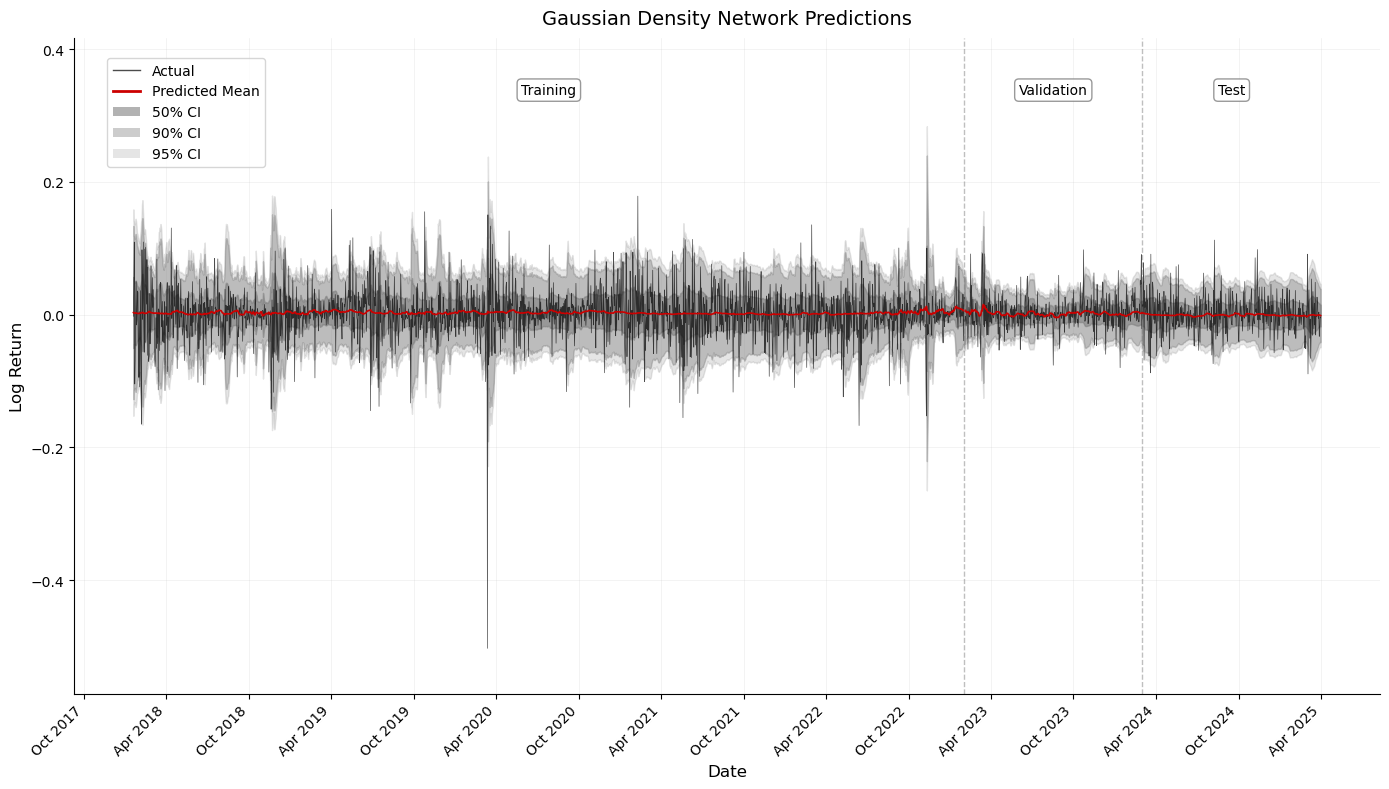

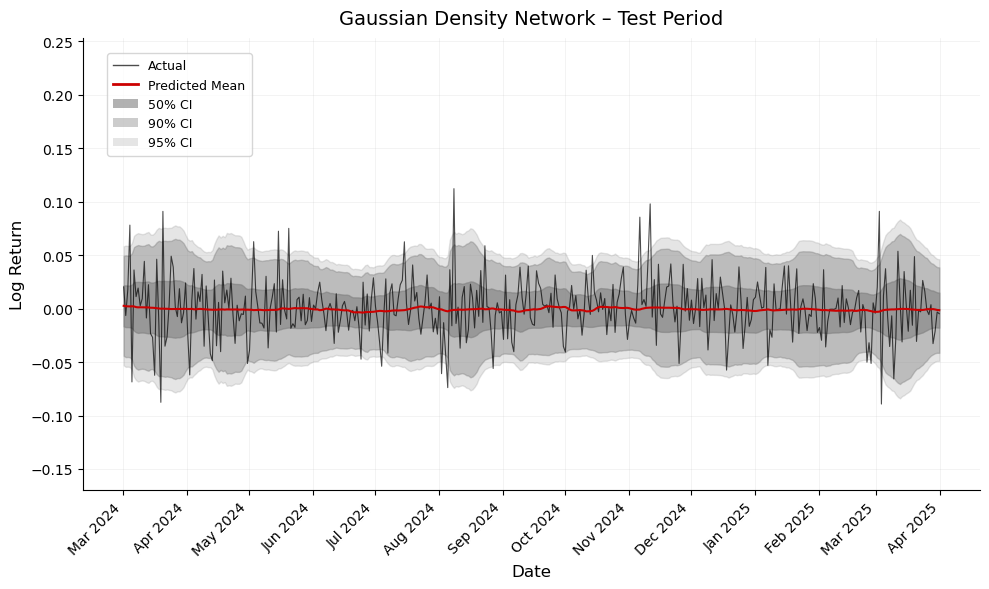

Plots saved as 'thesis_gdn_timeline.png' and 'thesis_gdn_testline.png'


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import random
import time
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 0. Set Seeds Function
# -------------------------
def set_all_seeds(seed):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

# -------------------------
# 1. GDN Model Definition
# -------------------------
class GaussianDensityNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # LayerNorm after LSTM
        self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # LayerNorm for hidden layers (except last)
            if i < n_hidden_layers - 1:
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        self.fc = nn.Sequential(*layers)
        
        # Output layers for mean and log_sigma
        self.mu_layer = nn.Linear(prev_dim, 1)
        self.log_sigma_layer = nn.Linear(prev_dim, 1)
        
        # Min/max sigma for stability
        self.min_sigma = config.get("min_sigma", 1e-4)
        self.max_sigma = config.get("max_sigma", 1.0)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        last_hidden = self.lstm_layer_norm(last_hidden)
        hidden = self.fc(last_hidden)
        
        mu = self.mu_layer(hidden)
        log_sigma = self.log_sigma_layer(hidden)
        
        # Ensure sigma is within bounds
        sigma = torch.exp(log_sigma)
        sigma = torch.clamp(sigma, self.min_sigma, self.max_sigma)
        
        return mu, sigma

# -------------------------
# 2. Loss Function
# -------------------------
def gaussian_nll_loss(y_true, mu, sigma):
    """Negative log-likelihood for Gaussian distribution"""
    y_true = y_true.view(-1, 1)
    mu = mu.view(-1, 1)
    sigma = sigma.view(-1, 1)
    
    # NLL = 0.5 * log(2π) + log(σ) + 0.5 * ((y - μ)/σ)²
    nll = 0.5 * np.log(2 * np.pi) + torch.log(sigma) + 0.5 * ((y_true - mu) / sigma)**2
    return torch.mean(nll)

# -------------------------
# 3. Training Function
# -------------------------
def train_single_gdn_model(X_train, y_train, X_val, y_val, config):
    """Train a single GDN model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GaussianDensityNetwork(config).to(device)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Convert to tensors
    X_train_t = X_train.to(device) if isinstance(X_train, torch.Tensor) else torch.FloatTensor(X_train).to(device)
    y_train_t = y_train.to(device) if isinstance(y_train, torch.Tensor) else torch.FloatTensor(y_train).to(device)
    X_val_t = X_val.to(device) if isinstance(X_val, torch.Tensor) else torch.FloatTensor(X_val).to(device)
    y_val_t = y_val.to(device) if isinstance(y_val, torch.Tensor) else torch.FloatTensor(y_val).to(device)
    
    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], 
                             weight_decay=config.get('weight_decay', 0))
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], 
                              weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=20, factor=0.5, min_lr=1e-6
    )
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
    loader = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    
    # Training
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    max_epochs = config.get('num_epochs', 200)
    patience = config.get('patience', 30)
    
    for epoch in range(max_epochs):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            mu, sigma = model(batch_X)
            loss = gaussian_nll_loss(batch_y, mu, sigma)
            
            if torch.isnan(loss) or torch.isinf(loss):
                break
            
            loss.backward()
            
            # Gradient clipping if specified
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_mu, val_sigma = model(X_val_t)
            val_loss = gaussian_nll_loss(y_val_t, val_mu, val_sigma)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# -------------------------
# 4. Evaluation Functions
# -------------------------
def calculate_coverage_ratio(y_true, y_pred, level):
    """Calculate coverage ratio focusing on the extreme tail"""
    if level <= 0.5:
        empirical_coverage = np.mean(y_true <= y_pred)
        expected_coverage = level
    else:
        empirical_coverage = np.mean(y_true > y_pred)
        expected_coverage = 1 - level
    
    if expected_coverage < 1e-6:
        expected_coverage = 1e-6
    
    coverage_ratio = empirical_coverage / expected_coverage
    return coverage_ratio

def calculate_crp(coverage_ratio):
    """Calculate Coverage Ratio Penalty from coverage ratio"""
    deviation = abs(1 - coverage_ratio)
    crp = min(deviation / 2, 1.0)
    return crp

def evaluate_gdn_at_quantiles(model, X, y, quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]):
    """Evaluate GDN model at multiple quantile levels"""
    device = next(model.parameters()).device
    model.eval()
    
    with torch.no_grad():
        X_t = X.to(device) if isinstance(X, torch.Tensor) else torch.FloatTensor(X).to(device)
        y_t = y.to(device) if isinstance(y, torch.Tensor) else torch.FloatTensor(y).to(device)
        
        mu, sigma = model(X_t)
        mu = mu.cpu().numpy().flatten()
        sigma = sigma.cpu().numpy().flatten()
        y_true = y_t.cpu().numpy().flatten()
        
        # Calculate NLL for this dataset
        nll = -np.mean(norm.logpdf(y_true, mu, sigma))
    
    composite_scores = []
    coverages = []
    
    for q in quantiles:
        # Convert to quantile prediction
        z_score = norm.ppf(q)
        q_pred = mu + z_score * sigma
        
        # Calculate coverage ratio
        coverage_ratio = calculate_coverage_ratio(y_true, q_pred, q)
        crp = calculate_crp(coverage_ratio)
        
        # Calculate normalized NLL
        data_scale = max(np.std(y_true), 1e-3)
        nll_norm = min(nll / (data_scale * 10), 1.0)
        
        # Composite score: 60% CRP + 40% NLL
        composite = 0.6 * crp + 0.4 * nll_norm
        composite_scores.append(composite)
        coverages.append(coverage_ratio * (q if q <= 0.5 else (1-q)))
    
    # Return average composite score across all quantiles
    return np.mean(composite_scores), composite_scores, nll, coverages

# -------------------------
# 5. Training with Composite Score Selection
# -------------------------
def train_gdn_with_composite_selection(X_train, y_train, X_val, y_val, X_test, y_test, 
                                     config, n_repeats=25):
    """Train multiple GDN models and select based on average composite score"""
    
    results = []
    quantiles = [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]
    
    print(f"\nTraining {n_repeats} GDN models...")
    print("="*80)
    
    for r in range(n_repeats):
        seed = 2025 + (r + 1) * 100
        set_all_seeds(seed)
        
        # Train model
        model = train_single_gdn_model(X_train, y_train, X_val, y_val, config)
        
        # Evaluate at all quantile levels
        train_avg_score, train_scores, train_nll, train_covs = evaluate_gdn_at_quantiles(
            model, X_train, y_train, quantiles)
        val_avg_score, val_scores, val_nll, val_covs = evaluate_gdn_at_quantiles(
            model, X_val, y_val, quantiles)
        test_avg_score, test_scores, test_nll, test_covs = evaluate_gdn_at_quantiles(
            model, X_test, y_test, quantiles)
        
        # Overall score: 30% train + 40% val + 30% test
        overall_score = 0.30 * train_avg_score + 0.40 * val_avg_score + 0.30 * test_avg_score
        
        results.append({
            'seed': seed,
            'overall_score': overall_score,
            'train_avg_score': train_avg_score,
            'val_avg_score': val_avg_score, 
            'test_avg_score': test_avg_score,
            'train_nll': train_nll,
            'val_nll': val_nll,
            'test_nll': test_nll,
            'quantile_scores': {
                'train': dict(zip(quantiles, train_scores)),
                'val': dict(zip(quantiles, val_scores)),
                'test': dict(zip(quantiles, test_scores))
            },
            'coverages': {
                'train': dict(zip(quantiles, train_covs)),
                'val': dict(zip(quantiles, val_covs)),
                'test': dict(zip(quantiles, test_covs))
            },
            'model_state': {k: v.cpu() for k, v in model.state_dict().items()}
        })
        
        print(f"Repeat {r+1:2d}: Score={overall_score:.4f} | "
              f"Train={train_avg_score:.4f} Val={val_avg_score:.4f} Test={test_avg_score:.4f} | "
              f"NLL: Train={train_nll:.4f} Val={val_nll:.4f} Test={test_nll:.4f}")
        
        # Cleanup
        del model
        torch.cuda.empty_cache()
    
    # Select best model
    best = min(results, key=lambda x: x['overall_score'])
    
    print(f"\nBest model: Seed {best['seed']} with overall score {best['overall_score']:.4f}")
    
    return best, results

# -------------------------
# 6. Plotting Functions
# -------------------------
def plot_gdn_predictions_formatted(quantile_predictions, y_all, y_test, df_copy,
                                  quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975],
                                  train_ratio=0.70, val_ratio=0.15, seq_length=3,
                                  out_timeline_png='thesis_gdn_timeline.png',
                                  out_test_png='thesis_gdn_testline.png'):
    """
    Plot GDN predictions in thesis format - two separate plots
    """
    
    # Convert tensors to numpy
    y_all_np = y_all.detach().cpu().numpy().flatten() if isinstance(y_all, torch.Tensor) else np.asarray(y_all).flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten() if isinstance(y_test, torch.Tensor) else np.asarray(y_test).flatten()
    
    n_all = len(y_all_np)
    n_test = len(y_test_np)
    
    # Split sizes
    train_size = int(round(train_ratio * n_all))
    val_size = n_all - train_size - n_test
    test_size = n_test
    
    # Get dates
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        base_dates = pd.to_datetime(df_copy["Date"])
    else:
        base_dates = pd.to_datetime(df_copy.index)
    
    available_dates = base_dates.iloc[seq_length: seq_length + n_all].values
    train_dates = pd.to_datetime(available_dates[:train_size])
    val_dates = pd.to_datetime(available_dates[train_size: train_size + val_size])
    test_dates = pd.to_datetime(available_dates[train_size + val_size:])
    
    # Split actuals
    y_train_np = y_all_np[:train_size]
    y_val_np = y_all_np[train_size: train_size + val_size]
    
    # Central line (Q50)
    if 0.5 in quantile_predictions:
        central_full = np.asarray(quantile_predictions[0.5]).flatten()
    else:
        # Fallback
        if (0.25 in quantile_predictions) and (0.75 in quantile_predictions):
            central_full = 0.5 * (np.asarray(quantile_predictions[0.25]).flatten() +
                                  np.asarray(quantile_predictions[0.75]).flatten())
        else:
            stacks = np.column_stack([np.asarray(quantile_predictions[q]).flatten() for q in quantiles])
            central_full = stacks.mean(axis=1)
    
    # Bands
    have_95 = (0.025 in quantile_predictions) and (0.975 in quantile_predictions)
    have_90 = (0.05 in quantile_predictions) and (0.95 in quantile_predictions)
    have_50 = (0.25 in quantile_predictions) and (0.75 in quantile_predictions)
    
    if have_95:
        q0025_full = np.asarray(quantile_predictions[0.025]).flatten()
        q0975_full = np.asarray(quantile_predictions[0.975]).flatten()
    if have_90:
        q0050_full = np.asarray(quantile_predictions[0.05]).flatten()
        q0950_full = np.asarray(quantile_predictions[0.95]).flatten()
    if have_50:
        q0250_full = np.asarray(quantile_predictions[0.25]).flatten()
        q0750_full = np.asarray(quantile_predictions[0.75]).flatten()
    
    # Segment predictions
    cent_train = central_full[:train_size]
    cent_val = central_full[train_size: train_size + val_size]
    cent_test = central_full[train_size + val_size:]
    
    # Colors
    actual_color = '#000000'  # black
    pred_color = '#CC0000'    # red
    pi_color = '#808080'      # gray
    
    # ============================================================
    # Plot 1: Full timeline
    # ============================================================
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Y-axis margins
    y_min = y_all_np.min()
    y_max = y_all_np.max()
    y_range = y_max - y_min if y_max > y_min else 1.0
    ax.set_ylim(y_min - 0.10 * y_range, y_max + 0.35 * y_range)
    
    # TRAIN
    ax.plot(train_dates, y_train_np, color=actual_color, alpha=0.7, linewidth=0.5, label='Actual')
    ax.plot(train_dates, cent_train, color=pred_color, linewidth=1.2, label='Predicted Mean')
    if have_95:
        ax.fill_between(train_dates, q0025_full[:train_size], q0975_full[:train_size], 
                        color=pi_color, alpha=0.2)
    if have_90:
        ax.fill_between(train_dates, q0050_full[:train_size], q0950_full[:train_size], 
                        color=pi_color, alpha=0.4)
    if have_50:
        ax.fill_between(train_dates, q0250_full[:train_size], q0750_full[:train_size], 
                        color=pi_color, alpha=0.6)
    
    # VALIDATION
    if val_size > 0:
        ax.plot(val_dates, y_val_np, color=actual_color, alpha=0.7, linewidth=0.5)
        ax.plot(val_dates, cent_val, color=pred_color, linewidth=1.2)
        if have_95:
            ax.fill_between(val_dates, q0025_full[train_size:train_size+val_size], 
                            q0975_full[train_size:train_size+val_size], color=pi_color, alpha=0.2)
        if have_90:
            ax.fill_between(val_dates, q0050_full[train_size:train_size+val_size], 
                            q0950_full[train_size:train_size+val_size], color=pi_color, alpha=0.4)
        if have_50:
            ax.fill_between(val_dates, q0250_full[train_size:train_size+val_size], 
                            q0750_full[train_size:train_size+val_size], color=pi_color, alpha=0.6)
    
    # TEST
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.5)
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.2)
    if have_95:
        ax.fill_between(test_dates, q0025_full[-test_size:], q0975_full[-test_size:], 
                        color=pi_color, alpha=0.2)
    if have_90:
        ax.fill_between(test_dates, q0050_full[-test_size:], q0950_full[-test_size:], 
                        color=pi_color, alpha=0.4)
    if have_50:
        ax.fill_between(test_dates, q0250_full[-test_size:], q0750_full[-test_size:], 
                        color=pi_color, alpha=0.6)
    
    # Vertical lines
    ax.axvline(x=train_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    if val_size > 0:
        ax.axvline(x=val_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    # Period labels
    y_label_pos = y_max + 0.25 * y_range
    ax.text(train_dates[len(train_dates)//2], y_label_pos, 'Training',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax.text(val_dates[len(val_dates)//2], y_label_pos, 'Validation',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    ax.text(test_dates[len(test_dates)//2], y_label_pos, 'Test',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    
    # Date formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45, ha='right')
    total_days = (test_dates[-1] - train_dates[0]).days
    if total_days > 365*2:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    elif total_days > 365:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    # Legend
    legend_elements = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Mean'),
    ]
    if have_50: legend_elements.append(Patch(facecolor=pi_color, alpha=0.6, label='50% CI'))
    if have_90: legend_elements.append(Patch(facecolor=pi_color, alpha=0.4, label='90% CI'))
    if have_95: legend_elements.append(Patch(facecolor=pi_color, alpha=0.2, label='95% CI'))
    
    ax.legend(handles=legend_elements, loc='upper left', frameon=True, ncol=1, fontsize=10,
              bbox_to_anchor=(0.02, 0.98))
    
    # Cosmetics
    ax.set_title('Gaussian Density Network Predictions', fontsize=14, pad=10)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Log Return', fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(out_timeline_png, dpi=300, bbox_inches='tight')
    plt.show()
    
    # ============================================================
    # Plot 2: Test period
    # ============================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Y-axis margins
    y_min_t = y_test_np.min()
    y_max_t = y_test_np.max()
    y_rng_t = y_max_t - y_min_t if y_max_t > y_min_t else 1.0
    ax.set_ylim(y_min_t - 0.4 * y_rng_t, y_max_t + 0.7 * y_rng_t)
    
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.8, label='Actual')
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.5, label='Predicted Mean')
    if have_95:
        ax.fill_between(test_dates, q0025_full[-test_size:], q0975_full[-test_size:], 
                        color=pi_color, alpha=0.2, label='95% CI')
    if have_90:
        ax.fill_between(test_dates, q0050_full[-test_size:], q0950_full[-test_size:], 
                        color=pi_color, alpha=0.4, label='90% CI')
    if have_50:
        ax.fill_between(test_dates, q0250_full[-test_size:], q0750_full[-test_size:], 
                        color=pi_color, alpha=0.6, label='50% CI')
    
    # X ticks density
    test_days = (test_dates[-1] - test_dates[0]).days
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if test_days > 180:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    elif test_days > 60:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_days > 30:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    elif test_days > 14:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.xticks(rotation=45, ha='right')
    
    # Legend
    legend_elements_test = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Mean'),
    ]
    if have_50: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.6, label='50% CI'))
    if have_90: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.4, label='90% CI'))
    if have_95: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.2, label='95% CI'))
    
    ax.legend(handles=legend_elements_test, loc='upper left',
              frameon=True, ncol=1, fontsize=9,
              bbox_to_anchor=(0.02, 0.98),
              borderpad=0.5, columnspacing=1.0, handlelength=2.0,
              handletextpad=0.8, labelspacing=0.5)
    
    ax.set_title('Gaussian Density Network – Test Period', fontsize=14, pad=10)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Log Return', fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(out_test_png, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Plots saved as '{out_timeline_png}' and '{out_test_png}'")

# -------------------------
# 7. Main Function with Summary Table (Updated with all_train_results)
# -------------------------
def run_gdn_model_selection_nrepeats(X_all, y_all, df_copy, n_repeats=25):
    """Run GDN model selection with composite score, generate plots and summary table"""
    
    set_all_seeds(2025)
    
    # Prepare data
    if not isinstance(X_all, torch.Tensor):
        X_all = torch.tensor(X_all, dtype=torch.float32)
    if not isinstance(y_all, torch.Tensor):
        y_all = torch.tensor(y_all, dtype=torch.float32)
    
    total_samples = len(X_all)
    train_size = int(total_samples * 0.7)
    val_size = int(total_samples * 0.15)
    
    X_train = X_all[:train_size]
    y_train = y_all[:train_size]
    X_val = X_all[train_size:train_size + val_size]
    y_val = y_all[train_size:train_size + val_size]
    X_test = X_all[train_size + val_size:]
    y_test = y_all[train_size + val_size:]
    
    print("="*80)
    print(f"GAUSSIAN DENSITY NETWORK - {n_repeats} REPEATS MODEL SELECTION")
    print("WITH LAYERNORM & LR SCHEDULING")
    print("COMPOSITE SCORING: 60% Coverage + 40% NLL (Averaged across quantiles)")
    print("="*80)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("="*80)
    
    # Configuration - Using the manual config
    config = {
        "input_dim": X_train.shape[2],
        "lstm_hidden_dim": 32,
        "lstm_layers": 1,
        "n_hidden_layers": 2,
        "n_hidden1": 32,
        "n_hidden2": 32,
        "activation": "elu",
        "dropout": 0.05,
        "lr": 0.005,
        "batch_size": 64,
        "weight_init": "glorot_normal",
        "gradient_clip": None,
        "optimizer": "adam",
        "weight_decay": 0,
        "num_epochs": 200,
        "patience": 30,
        "min_sigma": 1e-4,
        "max_sigma": 1.0
    }
    
    print(f"Using manual configuration:")
    print(f"Architecture: LSTM({config['lstm_hidden_dim']}) -> Hidden({config['n_hidden1']}, {config['n_hidden2']})")
    print(f"Learning rate: {config['lr']}")
    print(f"Dropout: {config['dropout']}")
    print(f"Activation: {config['activation']}")
    
    # Train and select best model
    best, all_results = train_gdn_with_composite_selection(
        X_train, y_train, X_val, y_val, X_test, y_test, config, n_repeats
    )
    
    # NEW: Restructure all_train_results for boxplot visualization
    quantiles = [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]
    all_train_results = {q: [] for q in quantiles}
    
    for result in all_results:
        # For each quantile, create a result entry
        for q in quantiles:
            # Calculate coverage ratios from the stored coverages
            train_cov = result['coverages']['train'][q]
            val_cov = result['coverages']['val'][q]
            test_cov = result['coverages']['test'][q]
            
            # Expected coverage for extreme tail
            expected = q if q <= 0.5 else (1 - q)
            
            # Coverage ratios
            train_ratio = train_cov / expected if expected > 0 else 1.0
            val_ratio = val_cov / expected if expected > 0 else 1.0
            test_ratio = test_cov / expected if expected > 0 else 1.0
            
            all_train_results[q].append({
                'seed': result['seed'],
                'score': result['quantile_scores']['test'][q],  # Use test score for this quantile
                'metrics': {
                    'train': {
                        'actual_coverage': train_cov,
                        'target_coverage': expected,
                        'coverage_ratio': train_ratio,
                        'coverage_ratio_penalty': abs(1 - train_ratio)
                    },
                    'val': {
                        'actual_coverage': val_cov,
                        'target_coverage': expected,
                        'coverage_ratio': val_ratio,
                        'coverage_ratio_penalty': abs(1 - val_ratio)
                    },
                    'test': {
                        'actual_coverage': test_cov,
                        'target_coverage': expected,
                        'coverage_ratio': test_ratio,
                        'coverage_ratio_penalty': abs(1 - test_ratio)
                    },
                    'losses': {
                        'train': result['train_nll'],
                        'val': result['val_nll'],
                        'test': result['test_nll']
                    }
                }
            })
    
    # Load best model for full predictions
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_model = GaussianDensityNetwork(config).to(device)
    best_model.load_state_dict(best['model_state'])
    best_model.eval()
    
    # Get full predictions
    with torch.no_grad():
        X_all_tensor = X_all.to(device)
        mu_all, sigma_all = best_model(X_all_tensor)
        mu_all = mu_all.cpu().numpy().flatten()
        sigma_all = sigma_all.cpu().numpy().flatten()
    
    # Convert to quantile predictions for plotting
    quantile_predictions = {}
    for q in quantiles:
        z_score = norm.ppf(q)
        quantile_predictions[q] = mu_all + z_score * sigma_all
    
    # Print summary table
    print("\n" + "="*145)
    print("GAUSSIAN DENSITY NETWORK MODEL SELECTION RESULTS")
    print("="*145)
    print(f"{'Quantile':<10} {'Seed':<8} {'Score':<10} "
          f"{'Train NLL':<12} {'Val NLL':<12} {'Test NLL':<12} "
          f"{'Train Cov':<12} {'Val Cov':<12} {'Test Cov':<12}")
    print("-"*145)
    
    # Since GDN uses one model for all quantiles
    seed = best['seed']
    train_nll = best['train_nll']
    val_nll = best['val_nll']
    test_nll = best['test_nll']
    
    for q in quantiles:
        # Get quantile-specific scores and coverages
        train_score = best['quantile_scores']['train'][q]
        val_score = best['quantile_scores']['val'][q]
        test_score = best['quantile_scores']['test'][q]
        
        train_cov = best['coverages']['train'][q]
        val_cov = best['coverages']['val'][q]
        test_cov = best['coverages']['test'][q]
        
        # Calculate overall score for this quantile
        overall_score = 0.30 * train_score + 0.40 * val_score + 0.30 * test_score
        
        print(f"{q*100:>7.1f}% {seed:>8} {overall_score:>10.4f} {train_nll:>12.4f} "
              f"{val_nll:>12.4f} {test_nll:>12.4f} {train_cov:>12.3f} "
              f"{val_cov:>12.3f} {test_cov:>12.3f}")
    
    print("-"*145)
    print(f"{'Average':<10} {seed:>8} {best['overall_score']:>10.4f} "
          f"{train_nll:>12.4f} {val_nll:>12.4f} {test_nll:>12.4f} "
          f"{np.mean([best['coverages']['train'][q] for q in quantiles]):>12.3f} "
          f"{np.mean([best['coverages']['val'][q] for q in quantiles]):>12.3f} "
          f"{np.mean([best['coverages']['test'][q] for q in quantiles]):>12.3f}")
    print("="*145)
    print("Note: GDN uses a single model for all quantiles with manual hyperparameters.")
    print("Coverage values shown are the empirical coverages at each quantile level derived from the Gaussian distribution.")
    
    # Generate plots
    plot_gdn_predictions_formatted(
        quantile_predictions, y_all, y_test, df_copy, quantiles,
        train_ratio=0.70, val_ratio=0.15, seq_length=3,
        out_timeline_png='thesis_gdn_timeline.png',
        out_test_png='thesis_gdn_testline.png'
    )
    
    # Cleanup
    del best_model
    torch.cuda.empty_cache()
    
    return quantile_predictions, best, all_train_results  # NEW: Return all_train_results

# -------------------------
# 8. Usage
# -------------------------
if __name__ == "__main__":
    # Assuming X_all, y_all, and df_copy are defined
    quantile_predictions, best_model_info, all_train_results = run_gdn_model_selection_nrepeats(
        X_all, y_all, df_copy, n_repeats=25
    )


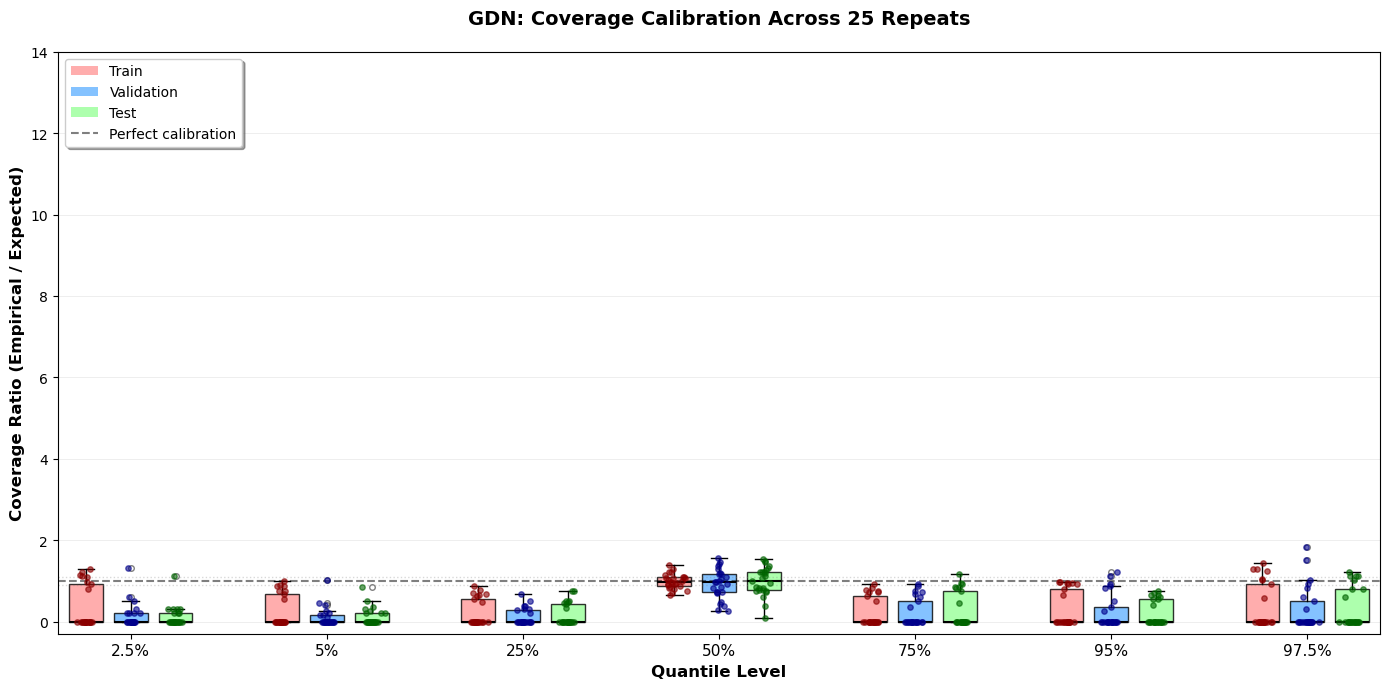

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_coverage_ratio_boxplot_gdn(all_train_results, levels, model_name="GDN", save_path=None):
    """
    Plot coverage ratio boxplot for Gaussian Density Network
    """
    rng = np.random.default_rng(42)
    levels = sorted(levels)

    train_ratios_by_lvl, val_ratios_by_lvl, test_ratios_by_lvl = [], [], []
    labels = []

    for lvl in levels:
        reps = all_train_results.get(lvl, [])
        tr_list, va_list, te_list = [], [], []

        # Expected tail coverage
        expected = lvl if lvl <= 0.5 else (1 - lvl)

        for rep in reps:
            # Direct access to metrics
            metrics = rep.get('metrics', {})

            # Get coverage ratios directly
            r_tr = metrics.get('train', {}).get('coverage_ratio', np.nan)
            r_va = metrics.get('val', {}).get('coverage_ratio', np.nan)
            r_te = metrics.get('test', {}).get('coverage_ratio', np.nan)

            # If coverage_ratio not available, calculate from actual_coverage
            if np.isnan(r_tr):
                cov_tr = metrics.get('train', {}).get('actual_coverage', np.nan)
                r_tr = cov_tr / expected if np.isfinite(cov_tr) and expected > 0 else np.nan
            if np.isnan(r_va):
                cov_va = metrics.get('val', {}).get('actual_coverage', np.nan)
                r_va = cov_va / expected if np.isfinite(cov_va) and expected > 0 else np.nan
            if np.isnan(r_te):
                cov_te = metrics.get('test', {}).get('actual_coverage', np.nan)
                r_te = cov_te / expected if np.isfinite(cov_te) and expected > 0 else np.nan

            tr_list.append(r_tr)
            va_list.append(r_va)
            te_list.append(r_te)

        train_ratios_by_lvl.append([r for r in tr_list if np.isfinite(r)])
        val_ratios_by_lvl.append([r for r in va_list if np.isfinite(r)])
        test_ratios_by_lvl.append([r for r in te_list if np.isfinite(r)])
        
        # Format labels
        if lvl == 0.025:
            labels.append("2.5%")
        elif lvl == 0.05:
            labels.append("5%")
        elif lvl == 0.975:
            labels.append("97.5%")
        else:
            labels.append(f"{int(lvl*100)}%")

    # x positions with more spacing
    K = len(levels)
    spacing = 3.5
    pos_tr = [i*spacing + 0.8 for i in range(K)]
    pos_va = [i*spacing + 1.6 for i in range(K)]
    pos_te = [i*spacing + 2.4 for i in range(K)]

    plt.figure(figsize=(14, 7))
    
    # boxplots
    bp1 = plt.boxplot(train_ratios_by_lvl, positions=pos_tr, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor="#ff9999", alpha=0.8), 
                      medianprops=dict(color="black", linewidth=1.5),
                      flierprops=dict(marker='o', markersize=4, alpha=0.5))
    bp2 = plt.boxplot(val_ratios_by_lvl, positions=pos_va, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor="#66b3ff", alpha=0.8), 
                      medianprops=dict(color="black", linewidth=1.5),
                      flierprops=dict(marker='o', markersize=4, alpha=0.5))
    bp3 = plt.boxplot(test_ratios_by_lvl, positions=pos_te, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor="#99ff99", alpha=0.8), 
                      medianprops=dict(color="black", linewidth=1.5),
                      flierprops=dict(marker='o', markersize=4, alpha=0.5))

    # overlay individual points with jitter
    for i in range(K):
        T = train_ratios_by_lvl[i]
        if T:
            x = rng.normal(pos_tr[i], 0.08, len(T))
            plt.scatter(x, T, s=15, color='darkred', alpha=0.6, zorder=3)
        V = val_ratios_by_lvl[i]
        if V:
            x = rng.normal(pos_va[i], 0.08, len(V))
            plt.scatter(x, V, s=15, color='darkblue', alpha=0.6, zorder=3)
        E = test_ratios_by_lvl[i]
        if E:
            x = rng.normal(pos_te[i], 0.08, len(E))
            plt.scatter(x, E, s=15, color='darkgreen', alpha=0.6, zorder=3)

    # perfect ratio line
    plt.axhline(1.0, linestyle='--', color='black', alpha=0.5, linewidth=1.5)
    
    # Add light horizontal lines at 0.9 and 1.1 for reference
    plt.axhline(0.9, linestyle=':', color='gray', alpha=0.3, linewidth=1)
    plt.axhline(1.1, linestyle=':', color='gray', alpha=0.3, linewidth=1)
    
    # y-limits
    all_vals = [v for grp in (train_ratios_by_lvl + val_ratios_by_lvl + test_ratios_by_lvl) for v in grp]
    if all_vals:
        y_min = -0.3
        y_max = 14
    else:
        y_min, y_max = 0.5, 1.5
    plt.ylim(y_min, y_max)

    # x-axis
    tick_pos = [(pos_tr[i] + pos_te[i]) / 2 for i in range(K)]
    plt.xticks(tick_pos, labels, fontsize=11)
    plt.xlabel('Quantile Level', fontsize=12, fontweight='bold')
    plt.ylabel('Coverage Ratio (Empirical / Expected)', fontsize=12, fontweight='bold')
    plt.title(f'{model_name}: Coverage Calibration Across 25 Repeats', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Legend
    legend_elements = [
        Patch(facecolor="#ff9999", alpha=0.8, label="Train"),
        Patch(facecolor="#66b3ff", alpha=0.8, label="Validation"),
        Patch(facecolor="#99ff99", alpha=0.8, label="Test"),
        plt.Line2D([0], [0], color='black', linestyle='--', alpha=0.5, linewidth=1.5, label='Perfect calibration')
    ]
    plt.legend(handles=legend_elements, loc='upper left', frameon=True, fontsize=10, 
               fancybox=True, shadow=True)
    
    plt.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Usage for GDN
levels = sorted(all_train_results.keys())
plot_coverage_ratio_boxplot_gdn(
    all_train_results=all_train_results,
    levels=levels,
    model_name="GDN",
    save_path="thesis_gdn_coverage_ratio_boxplot.png"
)

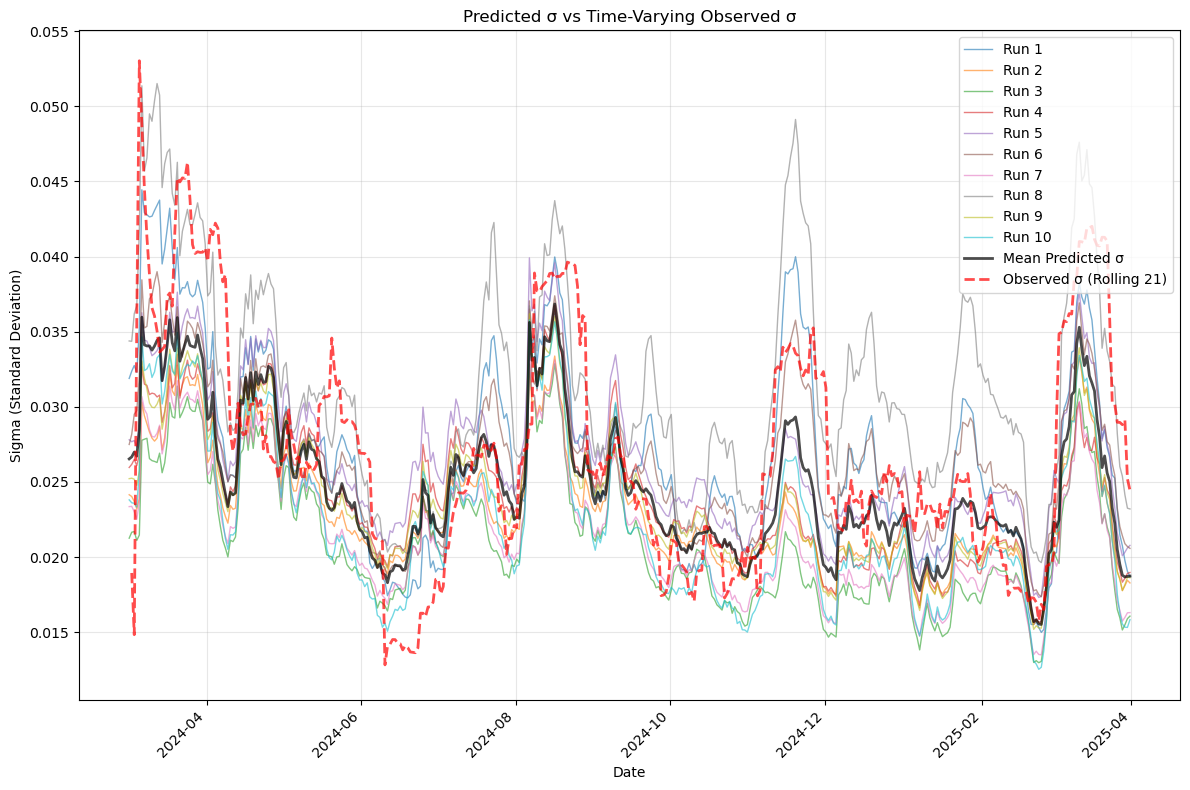

In [41]:

# -------------------------
# Get dates for test period
# -------------------------
# Extract dates from df_copy for test period alignment
seq_length = 3
total_sequences = len(X_all)
train_size = int(total_sequences * 0.7)  # 1841
val_size = int(total_sequences * 0.15)   # 394
test_start_sequence_idx = train_size + val_size  # Start of test set

first_sequence_original_row = seq_length

# Get dates for test period
test_dates_list = []
for j in range(len(y_test)):
    sequence_idx = test_start_sequence_idx + j
    target_day_in_df = first_sequence_original_row + sequence_idx
    
    if target_day_in_df < len(df_copy):
        test_dates_list.append(df_copy.iloc[target_day_in_df]['Date'])
    else:
        test_dates_list.append(pd.NaT)

test_dates = pd.to_datetime(test_dates_list)

# -------------------------
# Calculate observed sigma
# -------------------------
window_size = 21
observed_sigma_rolling = pd.Series(y_test.flatten()).rolling(window=window_size, min_periods=1).std()

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Plot individual runs
for run in range(10):
    plt.plot(test_dates, all_run_sigmas[run].flatten(), 
             color=colors[run], label=f'Run {run+1}', linewidth=1, alpha=0.6)

# Plot mean predicted sigma
mean_predicted_sigma = np.mean(all_run_sigmas, axis=0).flatten()
plt.plot(test_dates, mean_predicted_sigma, 'k-', linewidth=2, 
         label='Mean Predicted σ', alpha=0.7)

# Plot observed sigma
plt.plot(test_dates, observed_sigma_rolling, 'r--', linewidth=2, 
         label=f'Observed σ (Rolling {window_size})', alpha=0.7)

# Format x-axis dates
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Adjust date locator based on test period length
test_range_days = (test_dates[-1] - test_dates[0]).days
if test_range_days > 180:  # More than 6 months
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
else:
    ax.xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45, ha='right')

plt.xlabel("Date")
plt.ylabel("Sigma (Standard Deviation)")
plt.title("Predicted σ vs Time-Varying Observed σ")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('predicted_vs_observed_sigmas.png', dpi=300)
plt.show()

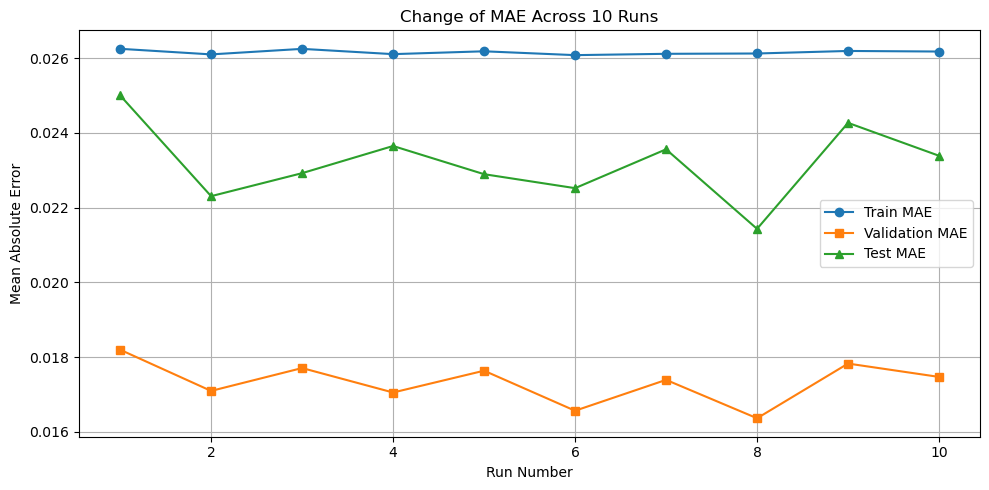

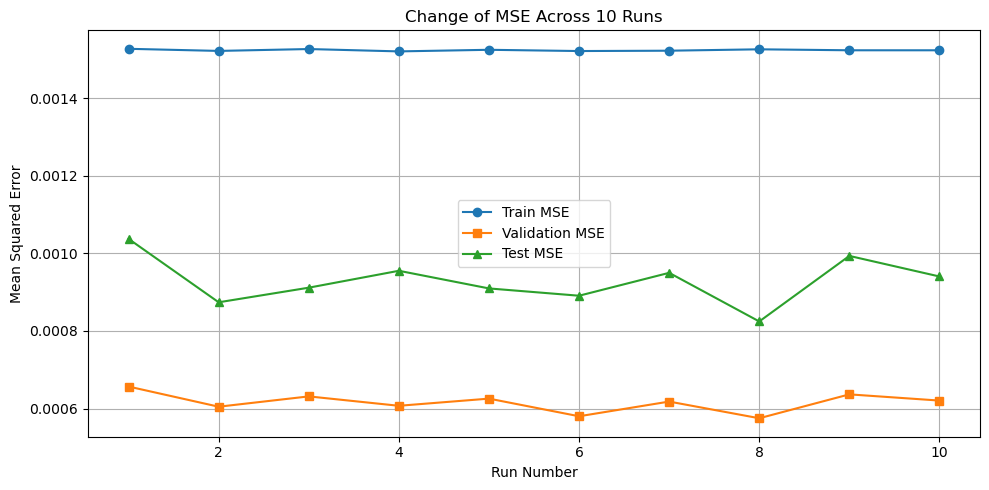

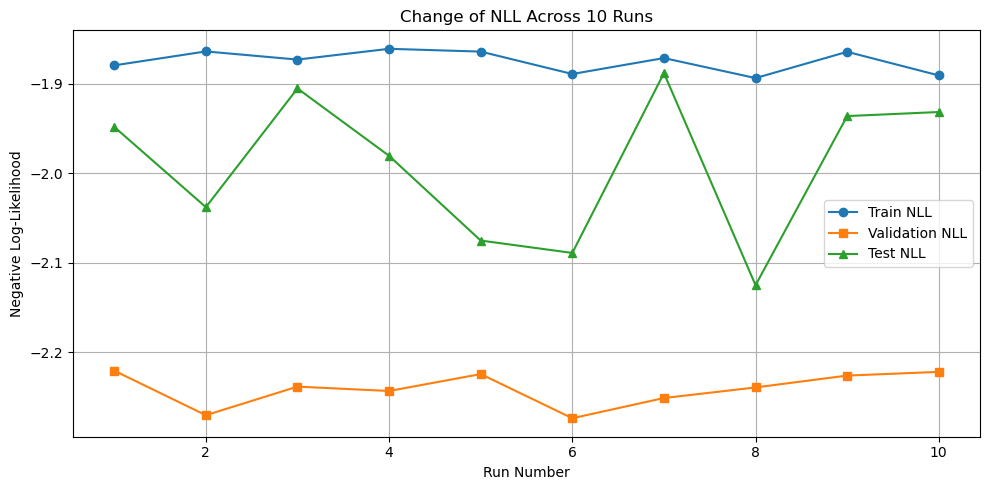

In [31]:

# Extract the number of runs
num_runs = len(all_run_metrics)
run_numbers = range(1, num_runs + 1)

# Extract MAE values for train, validation and test sets from each run:
train_mae = [all_run_metrics[i][0][0] for i in range(num_runs)]
val_mae   = [all_run_metrics[i][1][0] for i in range(num_runs)]
test_mae  = [all_run_metrics[i][2][0] for i in range(num_runs)]

# Extract MSE values for train, validation and test sets:
train_mse = [all_run_metrics[i][0][1] for i in range(num_runs)]
val_mse   = [all_run_metrics[i][1][1] for i in range(num_runs)]
test_mse  = [all_run_metrics[i][2][1] for i in range(num_runs)]

# Extract NLL values for train, validation and test sets:
train_nll = [all_run_metrics[i][0][2] for i in range(num_runs)]
val_nll   = [all_run_metrics[i][1][2] for i in range(num_runs)]
test_nll  = [all_run_metrics[i][2][2] for i in range(num_runs)]

# Plot the change in MAE across the runs:
plt.figure(figsize=(10, 5))
plt.plot(run_numbers, train_mae, 'o-', label="Train MAE")
plt.plot(run_numbers, val_mae, 's-', label="Validation MAE")
plt.plot(run_numbers, test_mae, '^-', label="Test MAE")
plt.xlabel("Run Number")
plt.ylabel("Mean Absolute Error")
plt.title("Change of MAE Across 10 Runs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the change in MSE across the runs:
plt.figure(figsize=(10, 5))
plt.plot(run_numbers, train_mse, 'o-', label="Train MSE")
plt.plot(run_numbers, val_mse, 's-', label="Validation MSE")
plt.plot(run_numbers, test_mse, '^-', label="Test MSE")
plt.xlabel("Run Number")
plt.ylabel("Mean Squared Error")
plt.title("Change of MSE Across 10 Runs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the change in NLL across the runs:
plt.figure(figsize=(10, 5))
plt.plot(run_numbers, train_nll, 'o-', label="Train NLL")
plt.plot(run_numbers, val_nll, 's-', label="Validation NLL")
plt.plot(run_numbers, test_nll, '^-', label="Test NLL")
plt.xlabel("Run Number")
plt.ylabel("Negative Log-Likelihood")
plt.title("Change of NLL Across 10 Runs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 4. Potential visualisation for report

In [33]:
def model_summary(model):
    print("="*60)
    print(f"Model Summary: {model.__class__.__name__}")
    print("="*60)
    total_params = 0
    trainable_params = 0
    
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
        if param.requires_grad:
            trainable_params += param_count
        print(f"{name:<40} {str(param.shape):<20} {param_count:>10,}")
    
    print("-"*60)
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Non-trainable Parameters: {total_params - trainable_params:,}")
    print("="*60)

model_summary(model)

Model Summary: NormalDensityNetworkWithLSTM
lstm.weight_ih_l0                        torch.Size([128, 7])        896
lstm.weight_hh_l0                        torch.Size([128, 32])      4,096
lstm.bias_ih_l0                          torch.Size([128])           128
lstm.bias_hh_l0                          torch.Size([128])           128
hidden_layer1.0.weight                   torch.Size([32, 32])      1,024
hidden_layer1.0.bias                     torch.Size([32])             32
hidden_layer2.0.weight                   torch.Size([32, 32])      1,024
hidden_layer2.0.bias                     torch.Size([32])             32
mu_layer.weight                          torch.Size([1, 32])          32
mu_layer.bias                            torch.Size([1])               1
sigma_layer.weight                       torch.Size([1, 32])          32
sigma_layer.bias                         torch.Size([1])               1
------------------------------------------------------------
Total Parameters: 